In [1]:
import sys
import gempy as gp

%matplotlib inline
import pymc
import numpy as np
import math

from IPython.core.display import Image

from pymc.Matplot import plot
from pymc import graph

from IPython.core.pylabtools import figsize
figsize(15, 6)

import scipy.optimize as sop
import scipy.stats as stats
from scipy.signal import argrelextrema

import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

import importlib

from operator import itemgetter

from mpl_toolkits.mplot3d import Axes3D

import vtk
import evtk

from scipy.interpolate import griddata

#import pydot

In [2]:
# Importing the data from csv files and setting extent and resolution
geo_data = gp.create_data([0,2000,0,2000,0,2000],[100,100,100],
                         path_f = "./input_data/Fab_ResModel_Foliations2.csv",
                         path_i = "./input_data/Fab_ResModel_Points4_small_offset.csv")
geo_data.n_faults = 1

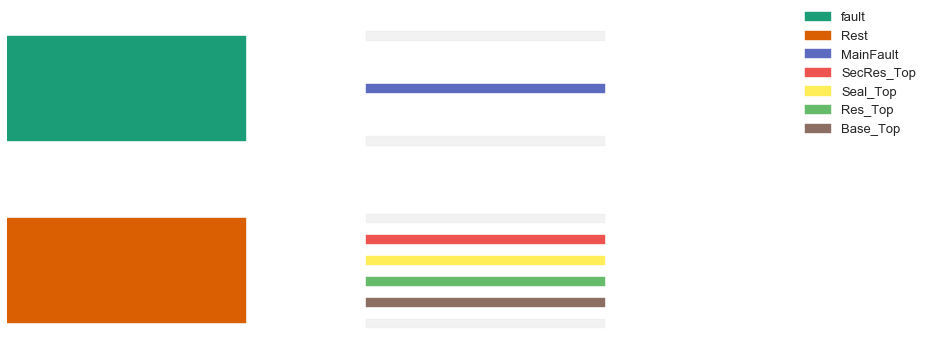

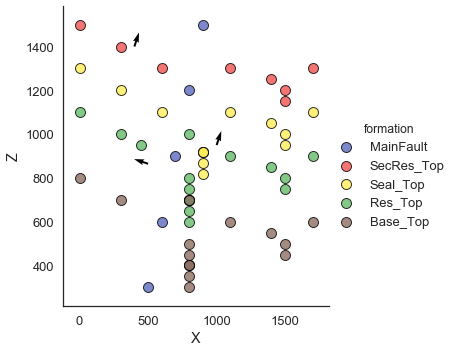

In [3]:
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest":('Base_Top', 'Res_Top', 'Seal_Top', 'SecRes_Top')},
                       order_series = ["fault","Rest",], order_formations=['MainFault', 
                                         'SecRes_Top', 'Seal_Top', 'Res_Top','Base_Top',
                                         ])

gp.plot_data(geo_data)

In [4]:
# Creating a row label 'fault side' to distinguish between footwall (FW) and hanging wall (HW)
geo_data.interfaces['fault side'] = 'nan'
HW_border = 1300 # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)
nonfault_cond = geo_data.interfaces['formation'] != 'MainFault'
fault_cond = geo_data.interfaces['formation'] == 'MainFault'

fw_x_cond = geo_data.interfaces['X'] > (geo_data.extent[:2][1] - HW_border) # condition for FW points

hw_x_cond = geo_data.interfaces['X'] < (geo_data.extent[:2][1] - HW_border) # condition for HW points

geo_data.interfaces.set_value(fw_x_cond,'fault side','footwall') # setting FW
geo_data.interfaces.set_value(hw_x_cond,'fault side','hanging wall') #setting HW
geo_data.interfaces.set_value(fault_cond,'fault side','nan'); # reverting fault points to 'nan'

In [5]:
# INTERPOLATION
interp_data = gp.InterpolatorInput(geo_data, 
                                   u_grade = [3, 3, 3],
                                   compile_theano=True, dtype ='float64')

Level of Optimization:  fast_run
Device:  cpu
Precision:  float64


In [6]:
# COMPUTATION OF THE MODEL
lith_sol, fault_sol = gp.compute_model(interp_data)

In [7]:
# Arrays to hold the original compuation of the model
# These is used in case of computation failure (singular matrix) during modeling under uncertainty
lith_holder = lith_sol
fault_holder = fault_sol
interp_holder = interp_data

In [8]:
# CREATING SURFACES FOR LAYERS
base_surf, base_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['Base_Top']))
res_surf, res_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['Res_Top']))
seal_surf, seal_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['Seal_Top']))
sec_res_surf, sec_res_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['SecRes_Top']))
#fault_surf, fault_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['MainFault']))

In [9]:
plot_3Dpoints = False
plot_3Dsurf = False

if plot_3Dpoints:
    # 3D plot points in VTK
    gp.plot_data_3D(geo_data)
elif plot_3Dsurf:
    # 3D plot points and surfaces in VTK
    gp.plot_surfaces_3D(geo_data, [base_surf, sec_res_surf, seal_surf, res_surf], 
                    [base_surf_simp, sec_res_surf_simp, seal_surf_simp, res_surf_simp], plot_data=False
                   )

In [11]:
# DECLARING SOME MODEL VARIABLES
resolution = geo_data.resolution[1] #resolution, standard: 50
model_size = geo_data.extent[:2][1] # 'real' model extent, here: 2000 m - cubic (what if not cubic?)
scale_factor = (model_size/resolution) # scale factor used for calculating voxel volumes in [m]
                                        # here: 2000/50 = 40
rescale_f = interp_data.rescaling_factor # rescaling factor from geo_data to interp_data

minmax_buffer = True # buffer around local min and max values [on/off] - not used atm

SSF_c = 3

C:\Users\Fabian\Anaconda3\lib\site-packages\gempy\Visualization.py:253: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  im = plt.imshow(plot_block[_a, _b, _c].T, origin="bottom", cmap=self._cmap, norm=self._norm,


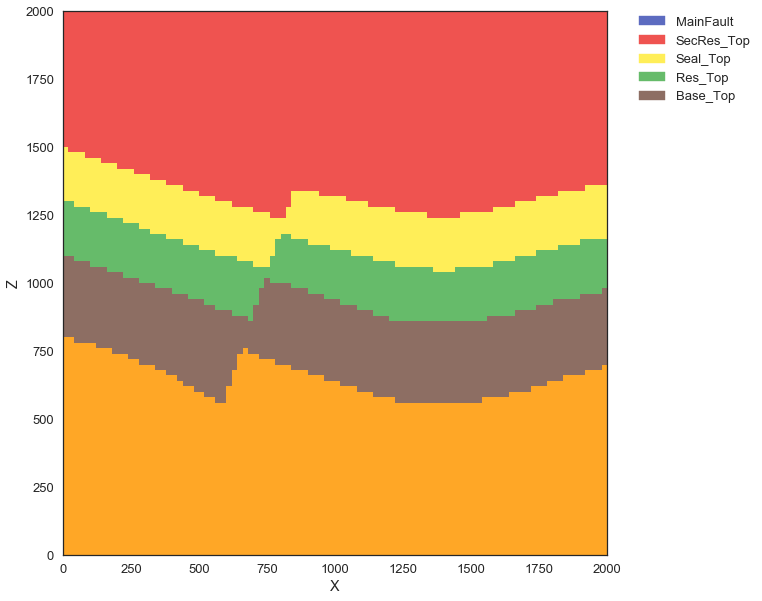

In [12]:
#%matplotlib notebook
%matplotlib inline
figsize(20,10)
gp.plot_section(geo_data, lith_sol[0], resolution/2, plot_data=0)

In [13]:
# FUNCTION TO FIND ANTICLINAL SPILL POINT AND CROSS-FAULT LEAK POINT

def spill_leak_P(interp_data, res_surf, lith, fault, print_figures=False):    
    
    # creating a grid with uniform distances for vertices of the reservoir surface
    grid_x, grid_y = np.meshgrid(np.unique(interp_data.geo_data_res.grid.grid[:, 0]),
                             np.unique(interp_data.geo_data_res.grid.grid[:, 1]))

    grid_x=(grid_x*rescale_f)-(np.min(grid_x)*rescale_f)
    grid_y=(grid_y*rescale_f)-(np.min(grid_y)*rescale_f)
    
    grid_z0 = griddata(res_surf[:,:2], res_surf[:,2],
                       (grid_x, grid_y), method='linear')
    
    # order of values that serve to find relative extrema (min/max)
    rel_order_maxX = 5
    rel_order_maxY = 10
    rel_order_minX = 5
    rel_order_minY = 5
    
    # check grid_z0 for max and min in directions x and y
    # direction X
    minX1,minX2 = argrelextrema(grid_z0,np.less,order=rel_order_minX,axis=1)
    maxX1,maxX2 = argrelextrema(grid_z0,np.greater,order=rel_order_maxX,axis=1)
    grid_minX = np.zeros_like(grid_z0)
    grid_minX[minX1,minX2]=1           # grid of min in X
    grid_maxX = np.zeros_like(grid_z0)
    grid_maxX[maxX1,maxX2]=1           # grid of max in X
    
    #direction Y
    minY1,minY2 = argrelextrema(grid_z0,np.less,order=rel_order_minY,axis=0)
    maxY1,maxY2 = argrelextrema(grid_z0,np.greater,order=rel_order_maxY,axis=0)
    grid_minY = np.zeros_like(grid_z0)
    grid_minY[minY1,minY2]=1           # grid of min in Y
    grid_maxY = np.zeros_like(grid_z0)
    grid_maxY[maxY1,maxY2]=1           # grid of max in Y
    
    # fault leak line: defining line of juxtaposition, point of cross-fault leakage to be found on it
    # check for minima line that is on hanging wall side compared to max contact of layer top with fault
    fault_max_line_bool = np.copy(grid_maxX)
    fault_max_line = fault_max_line_bool.argmax(axis=1)
    fault_max = np.max(fault_max_line) # max of fault-layer contact as threshold        
    fleak_line = np.copy(grid_minX).astype(int)
    fleak_line[:,fault_max:]=0 # only returns minima at hanging wall side
    
    # minmax buffering
    # to set neighboring values of min and max to min and max respectively, too 
    if minmax_buffer:
        minXroll1 = np.logical_or(grid_minX,np.roll(grid_minX,1, axis=0))
        minXroll1[:,:fault_max] = 0
        minXroll2 = np.logical_or(grid_minX,np.roll(grid_minX,-1, axis=0))
        minXroll2[:,:fault_max] = 0
        minXbuffer = np.logical_or(minXroll1, minXroll2)
        grid_minX = np.logical_or(grid_minX, minXbuffer)
        #grid_maxX = np.logical_or(grid_maxX,np.roll(grid_maxX,1))
        #grid_maxX = np.logical_or(grid_maxX,np.roll(grid_maxX,-1))
        #grid_minY = np.logical_or(grid_minY,np.roll(grid_minY,1))
        #grid_minY = np.logical_or(grid_minY,np.roll(grid_minY,-1))
        grid_maxY = np.logical_or(grid_maxY,np.roll(grid_maxY,1, axis=1))
        grid_maxY = np.logical_or(grid_maxY,np.roll(grid_maxY,-1, axis=1))
    
    #check for saddle points
    saddle_p1 = np.logical_and(grid_minX,grid_maxY)
    saddle_p2 = np.logical_and(grid_minY,grid_maxX)
    saddle_p_all= np.logical_or(saddle_p1, saddle_p2)
    
    # this should find saddle points relative to X and Y directions
    # problem of finding other points in a rotated direction?
    ### NOT FINISHED: DEFINE LEAK POINT OVER LEAK LINE MAX?
    
    # distinguish anticlinal spill points from fault leak points:
    pot_leak_points = np.logical_and(fleak_line,saddle_p_all)    
    pot_spill_points = saddle_p_all - pot_leak_points   # substracting leak bool from saddle point bool 
                                                        # to get spill point bool    
    # leak and spill point 3D coordinates
    # LEAK POINT
    pot_leak_Xcoord = grid_x[pot_leak_points]
    pot_leak_Ycoord = grid_y[pot_leak_points]
    pot_leak_Zcoord = grid_z0[pot_leak_points]    
    pot_leak_3Dcoord = np.array(list(zip(pot_leak_Xcoord, pot_leak_Ycoord, pot_leak_Zcoord)))
        
    if pot_leak_3Dcoord.size == 0:
        fault_leak_3Dcoord = np.array([]) # if no leak coordinates found, set to empty array
    else:
        max_leak_pos = pot_leak_3Dcoord[:,2].argmax(axis=0)
        fault_leak_3Dcoord = pot_leak_3Dcoord[max_leak_pos,:] # max is LP
        
    # SPILL POINT
    pot_spill_Xcoord = grid_x[pot_spill_points]
    pot_spill_Ycoord = grid_y[pot_spill_points]
    pot_spill_Zcoord = grid_z0[pot_spill_points]    
    pot_spill_3Dcoord = np.array(list(zip(pot_spill_Xcoord, pot_spill_Ycoord, pot_spill_Zcoord)))
    
    if pot_spill_3Dcoord.size == 0:
        anticline_spill_3Dcoord = np.array([]) # if no leak coordinates found, set to empty array
    else:
        max_spill_pos = pot_spill_3Dcoord[:,2].argmax(axis=0)
        anticline_spill_3Dcoord = pot_spill_3Dcoord[max_spill_pos,:] # max is SP
    
    # PLOTTING (for visualization and checking)
    # plot of min/max bools and all potential LPs(+) and SPs(x):
    if print_figures==True:
        figsize(15,6)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        #ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_minY, c="b", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_maxY, c="r", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_minX, c="b", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_maxX, c="r", alpha = 0.1)
        ax.scatter(grid_x, grid_y, pot_spill_points, c="black", alpha = 1, marker='x', s = 250)
        ax.scatter(grid_x, grid_y, pot_leak_points, c="black", alpha = 1, marker='+', s = 250)
        #ax.scatter(grid_x, grid_y, fleak_line, c="b", alpha = 1, marker='+', s= 250)
        #ax.scatter(grid_x, grid_y, leak_max[2], c="g", alpha = 1, marker='+', s= 250)
        
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        
        plt.show()
    
        # plot of reservoir top surface and position of all potential LPs(+) and SPs(x):
        plot_spill_leak(res_surf, pot_spill_points, anticline_spill_3Dcoord, fault_leak_3Dcoord, grid_x, grid_y, grid_z0)
    
    return anticline_spill_3Dcoord, fault_leak_3Dcoord

In [14]:
# LITHOLOGY BLOCK MASKING FUNCTIONS

# Masking function that confines to voxels which are part fo the reservoir formation,
# in the footwall side and above the z-horizontal defined by the spill or leak point
def res_mask(lith,fault, bottom_z, formation_nr):
    mask = np.ones_like(lith)
    mask[~formation_nr] = False
    mask[fault.astype(bool)] = False
    bottom_z = round((bottom_z/scale_factor)+0.5) #rounding up to avoid voxel connection to outside borders
    mask = mask.reshape(resolution,resolution,resolution)
    mask[:,:,:bottom_z] = False
    mask = mask.reshape(resolution**3,)
    return mask

def topo_analysis(lith, fault, fault_seal, seal_th):
    traps = []
    SSF = 0
    trap_control = 0
    # Padding of lith- and fault-block (creating border sections, formation number = 8)
    lith_pad = (np.pad(lith.reshape(resolution,resolution,resolution), 1, 'constant', constant_values = (8,8)))
    fault_pad = (np.pad(fault.reshape(resolution,resolution,resolution), 1, 'constant', constant_values = (8,8)))
    G, centroids, labels_unique, lith_to_labels_lot, labels_to_lith_lot, topo_block = \
    gp.topology_analyze(lith_pad, fault_pad, 1, areas_bool=False, return_block=True)
    # Finding sections which are possible traps in the reservoir (formation number = 7)
    trap_keys = [int(k) for k in lith_to_labels_lot["7"].keys()] # potential trap sections
    pad_keys = [int(p) for p in lith_to_labels_lot["8"].keys()] # model border sections
    secres_nr = interp_data.get_formation_number()['Seal_Top']
    over_nr = interp_data.get_formation_number()['SecRes_Top']
    res_nr = interp_data.get_formation_number()['Base_Top']
    base_keys = [int(b) for b in lith_to_labels_lot["0"].keys()]
    res_keys = [int(r) for r in lith_to_labels_lot["%s" % res_nr].keys()]
    secres_keys = [int(j) for j in lith_to_labels_lot["%s" % secres_nr].keys()] # sections in Secondary Reservoir
    over_keys = [int(o) for o in lith_to_labels_lot["%s" % over_nr].keys()] # section in Overlying
    tot_under_keys = np.append(res_keys, base_keys) # all sections that belong to underlying below seal
    tot_over_keys = np.append(secres_keys, over_keys) # all sections that belong to overlying above seal
    bool_block = np.zeros_like(topo_block)
    # If too many traps, model probably broken:
    print("NUMBER OF TRAPS", len(trap_keys))
    if len(trap_keys) > 10:
        trap_mask = bool_block[1:-1,1:-1,1:-1]
        SSF = 0
        trap_control = 0
        return trap_mask, SSF, trap_control
    else:
        # Check for each possible trap section, if it is connected to a border
        for tk in trap_keys:
            print('Checking Section:', tk)
            # Check for adjacency to model border
            if gp.topology_check_adjacency(G, tk, pad_keys[0]) == False:
                # Check for connection (juxtaposition!) to overlying layers (above seal) and SSF
                fault_seal_bool, SSF, trap_control = juxta_SSF_check(G, tk, res_keys, tot_under_keys, tot_over_keys, topo_block, seal_th)
                if fault_seal_bool == True:
                    traps.append(tk)
                    print('TRAP:', tk)
        if traps == []:
            print('No trap found! =(')
        else:
            for i in traps:
                # Creating a mask from the trap sections in the label block
                top_bool = topo_block == i
                bool_block[top_bool] = True
        # Removing padding
        trap_mask = bool_block[1:-1,1:-1,1:-1]
        return trap_mask, SSF, trap_control # this mask returns True for all voxels which were accepted as trap voxels

In [15]:
def juxta_SSF_check(G, tk, res_keys, tot_under_keys, tot_over_keys, topo_block, seal_th):
    throw = 0
    jp=0
    trap_c = 4
    # FIRST: check the adjacency area only for the trap: only the point of highest throw is relevant for SSF
    for tk in res_keys:
        for ok in tot_over_keys:  
            if gp.topology_check_adjacency(G, tk, ok) == True:
                if G.adj[tk][ok]['edge_type'] == 'stratigraphic':
                    print("Stratigraphic adjacency, leakage assumed!")
                    sealing = False
                    SSF = 0
                    trap_c = 4
                    return sealing, SSF, trap_c         # stratigraphic adjancency assumed to always leak 
                elif G.adj[tk][ok]['edge_type'] == 'fault':
                    trap_jshape = gp.Topology.compute_adj_shape(tk,ok,topo_block, ext=None)[3]
                    # fault throw at edge of trap section
                    if trap_jshape !=0:
                        y_ext = trap_jshape[1]
                        z_ext = trap_jshape[2]
                        # finding point of greatest throw for trap --> relevant for total fault throw and SSF
                        # bottom of trap is flat, so need to find only highest z-values for juxtaposition:
                        z_max = max(z_ext)
                        # finding the y.axis range in which this highest throw appears:
                        y_range = y_ext[z_ext==z_max]
                        y_min = min(y_range)
                        y_max = max(y_range)
                        jp+=1
                        
    # SECOND: check for adjancencies between all seal-underlying and seal-overlying formations to
    # determine total fault throw at point/range defined over trap (y_bool)
    if jp != 0:
        for uk in tot_under_keys:
            for ok in tot_over_keys:  
                if gp.topology_check_adjacency(G, uk, ok) == True:
                    #print("Adjacency with section:", ok)
                    if G.adj[uk][ok]['edge_type'] == 'stratigraphic':
                        print("Stratigraphic adjacency, leakage assumed!")
                        sealing = False
                        SSF = 0
                        trap_c = 4
                        return sealing, SSF, trap_c     # stratigraphic adjancency assumed to always leak
                    elif G.adj[uk][ok]['edge_type'] == 'fault':
                        # get the array for z-extent for this adj-area, then mask to relevant range
                        section_jshape = gp.Topology.compute_adj_shape(uk,ok,topo_block, ext=None)[3]
                        if section_jshape != 0:
                            section_z_ext = section_jshape[2]
                            # creating mask where values within this range = True --> to appl
                            section_y_ext = section_jshape[1]
                            y_ext_bool = np.logical_and(section_y_ext>=y_min, section_y_ext<=y_max)
                            y_bool_mask = np.copy(section_y_ext)
                            y_bool_mask[~y_ext_bool] = False
                            y_bool_mask[y_ext_bool] = True
                            if np.count_nonzero(y_bool_mask) != 0:
                                # the following can be used to find the throw height for one area
                                y_bool = y_bool_mask==True
                                section_z_range = section_z_ext[y_bool]
                                # get the throw height:
                                z_len = max(section_z_range)-min(section_z_range)+1
                                # calculate throw in [m] for this adjacency and add to total
                                section_throw = z_len*scale_factor
                                throw += section_throw
                                print("Adding %s to throw, adjacency between %s and %s" % (section_throw, uk, ok))
                                jp+=1
    if jp == 0:
        print('No JP with any layer over seal.')
        SSF = 0
        sealing = True
        trap_c = 0
        return sealing, SSF, trap_c
    else:
        print('JP with layer over seal, checking SSF.')
        tot_fault_throw = throw + seal_th
        SSF = tot_fault_throw/seal_th
        print('SSF = %s / %s = %s' % (tot_fault_throw, seal_th, SSF))
        if SSF > SSF_c:
            print('SSF threshold exceeded, shale smear assumed to be incomplete.')
            sealing = False
            trap_c = 3
            return sealing, SSF, trap_c
        else: 
            print('SSF in confidence range, complete shale smear sealing assumed.')
            sealing = True
            trap_c = 0
            return sealing, SSF, trap_c

In [16]:
# MAIN FUNCTION: Calculation of maximum fill volume in reservoir traps

def max_trap_vol(interp_data, lith, fault, res_surface, fault_sealing, seal_th):
    trap_control = 0 # intitiating variable that indicates what kind of mechanism controls the trap volume
                        # 0 = Unclear
                        # 1 = Spill Point
                        # 2 = Leak Point (LEAK UNDER)
                        # 3 = Seal breach juxtaposition leakage (LEAK OVER)
                        # 4 = Stratigraphical adjacency leakage
    bottom_surface = np.ones_like(res_surface) # needed?   
    spill_point, leak_point = spill_leak_P(interp_data, res_surface, lith, fault, print_figures=False)
    print("SPILL POINT AT:", spill_point)
    print("LEAK POINT AT:", leak_point)
    #CHECK: ONLY CONTINUE IF SPILL POINT FOUND, ELSE RETURN ZERO TRAP VOLUME
    if spill_point.size == 0:
        spill_z = np.nan
        print('No SPILL POINT found!')
        trap_vol = 0
        final_trap_mask = np.zeros_like(lith)
        return trap_vol, lith, bottom_surface, final_trap_mask    
    else:
        spill_z = spill_point[2]
        #spill_z, spill_p, spill_min_line, spill_bottom = spill_point(res_surface)
        # calculate leak point
        if leak_point.size == 0:
            print('No LEAK POINT found! So FULL LEAKAGE assumed!')
            leak_z = 2000
        else:
            leak_z = leak_point[2]
        #leak_z, leak_p, leak_line, leak_bottom = leak_point(res_surface)
        
        # Check for "down-to" z-horizon, maximum depth of reservoir
        # Check for fault sealing and subsequent relevance of leak point
        max_z = np.nanmax([spill_z, leak_z])   
        if max_z == spill_z:
            trap_control = 1
        else:
            trap_control = 2                
        
        res_nr = interp_data.get_formation_number()['Base_Top']
        res_nr_bool = lith == res_nr
        pre_trap_mask = res_mask(lith, fault, max_z, res_nr_bool)
          
        # volume cells for counting
        vol_cells = 0      
        
        pre_trap_mask_bool = (pre_trap_mask == True)
        # Check if there is anaything in the reservoir mask at all
        if np.count_nonzero(pre_trap_mask_bool) == 0:
            print("No res_formation above max_z!")
            SSF = 0
            trap_control = 0
            return 0, lith, bottom_surface, pre_trap_mask, SSF, trap_control
        else:
            lith[pre_trap_mask_bool] = 7                           # setting reservoir above bottom on footwall side 
            final_trap_mask, SSF, trap_c = topo_analysis(lith, fault, fault_sealing, seal_th)
            if trap_c == 3:
                trap_control = trap_c
            elif trap_c == 4:
                trap_control = trap_c
            lith[final_trap_mask] = 9                         # setting final trap to formation value = 9
            vol_cells = np.count_nonzero(final_trap_mask)
            
            #calulate volume from cells
            trap_vol = ((scale_factor)**3) * vol_cells 
            # revert to lith_block without any masks
            lith[pre_trap_mask_bool] = res_nr        
            #return the maximum reservoir volume
            return trap_vol, lith, bottom_surface, final_trap_mask, SSF, trap_control

In [17]:
# PLOTTING FUNCTIONS: Spill and leak point visualization
def plot_spill_leak(res_surface, pot_spills, spill_point, leak_point, grid_x, grid_y, grid_z0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
    #ax.scatter(grid_x, grid_y,pot_spills, c="r", alpha = 1, marker='p', s = 250)
    if spill_point.size != 0:        
        ax.scatter(spill_point[0],spill_point[1],spill_point[2], c="black", alpha = 1, marker='x', s = 250)
    if leak_point.size != 0:        
        ax.scatter(leak_point[0],leak_point[1],leak_point[2], c="black", alpha = 1, marker='+', s = 250)
        
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()

In [18]:
# for setting up postional conditions to determine thicknesses and the like:
fw_th_point = 900 # distance of test point for thickness from footwall border of model 
                  # (e.g.: X = 2000 - 900 = 1100)
HW_border = 1300 # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)

# SAVING ORIGINAL Z-VALUES (so they are not overwritten and can be used a base for every iteration)    
sec_res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top']['Z']
seal_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top']['Z']
res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Res_Top']['Z']
base_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Base_Top']['Z']

# SETTING Z-UNCERTAINTIES FOR EACH LAYER TOP
unc_f = 1
std_secres_top = 40 #* unc_f
std_seal_top = 60 #* unc_f
std_res_top = 80 #* unc_f
std_base_top = 100 #* unc_f
z_unc_secres_top = pymc.Normal('z_unc_secres_top', 0, 1./np.square(std_secres_top/rescale_f))
z_unc_seal_top = pymc.Normal('z_unc_seal_top', 0/rescale_f, 1./np.square(std_seal_top/rescale_f))
z_unc_res_top = pymc.Normal('z_unc_res_top', 0, 1./np.square(std_res_top/rescale_f))
z_unc_base_top = pymc.Normal('z_unc_base_top', 0, 1./np.square(std_base_top/rescale_f))

# SETTING FAULT OFFSET UNCERTAINTY
std_offset = 150
# using SkewNormal, so that fault offset is much more like to vary to a higher offset and to stay as a normal fault
offset_unc = pymc.SkewNormal('offset_unc', 0/rescale_f, 1./np.square(std_offset/rescale_f), alpha=-2)

# GENERAL FAULT SEALING UNCERTAINTY (p = probability of success (1 = True); True = fault sealing) # NOT USED!
 fault_sealing = pymc.Bernoulli('fault_sealing_unc',p=0)

In [19]:
# Boolean conditions to find data points for each formation
base_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Base_Top'
res_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Res_Top'
seal_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top'
secres_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top'

# Footwall and hanging wall conditions
footwall = interp_data.geo_data_res.interfaces['fault side'] == 'footwall'
hanging_wall = interp_data.geo_data_res.interfaces['fault side'] == 'hanging wall'

# Combining hanging wall and formation conditions
HW_secres_top = np.logical_and(secres_top_cond,hanging_wall)
HW_seal_top = np.logical_and(seal_top_cond,hanging_wall)
HW_res_top = np.logical_and(res_top_cond,hanging_wall)
HW_base_top = np.logical_and(base_top_cond,hanging_wall)

In [20]:
# PYMC MODEL FUNCTIONS 

# Updating of interp_data points with new z-values resulting from z-positional uncertainty
# and including offset uncertainty:
@pymc.deterministic
def interp_unc(value=0, z_unc_secres_top = z_unc_secres_top, z_unc_seal_top=z_unc_seal_top, 
                  z_unc_res_top = z_unc_res_top, z_unc_base_top = z_unc_base_top, off_unc=offset_unc):
    #print('CHECK0:', res_z)
    new_z_secres_top = sec_res_z + z_unc_secres_top
    new_z_seal_top = seal_z + z_unc_seal_top
    new_z_res_top = res_z + z_unc_res_top
    new_z_base_top = base_z + z_unc_base_top   
    
    # for offset uncertainty: additional change on hanging wall (HW): 
    HW_new_z_secres_top = new_z_secres_top + off_unc
    HW_new_z_seal_top = new_z_seal_top + off_unc
    HW_new_z_res_top = new_z_res_top + off_unc
    HW_new_z_base_top = new_z_base_top + off_unc

    print('Z variations top to bottom:', z_unc_secres_top*rescale_f, 
          z_unc_seal_top*rescale_f, z_unc_res_top*rescale_f, z_unc_base_top*rescale_f)  
    print('Fault offset variation:', off_unc*rescale_f)
    
    # FOOTWALL UNCERTAINTY
    interp_data.geo_data_res.interfaces.set_value(secres_top_cond,'Z',new_z_secres_top)
    interp_data.geo_data_res.interfaces.set_value(seal_top_cond,'Z',new_z_seal_top)
    interp_data.geo_data_res.interfaces.set_value(res_top_cond,'Z',new_z_res_top)
    interp_data.geo_data_res.interfaces.set_value(base_top_cond,'Z',new_z_base_top)
    
    # HANGING WALL UNCERTAINTY (incl. offset)
    interp_data.geo_data_res.interfaces.set_value(HW_secres_top,'Z',HW_new_z_secres_top)
    interp_data.geo_data_res.interfaces.set_value(HW_seal_top,'Z',HW_new_z_seal_top)
    interp_data.geo_data_res.interfaces.set_value(HW_res_top,'Z',HW_new_z_res_top)
    interp_data.geo_data_res.interfaces.set_value(HW_base_top,'Z',HW_new_z_base_top)
    
    #print('CHECK3:', interp_data.geo_data_res.interfaces)    
    return interp_data

# Calculating formation thickness based on z-difference between a bottom and top point on the footwall (fw)

# This is done using interp_data, where X,Y and Z-values are rescaled according to the rescaling_factor.
# Value[1] of extent_rescaled equals the maximum extent of model (here: 2000).
# So if we want to find the rescaled chosen X-position (here: 1100), 
# we simply calculate 2000-fw_th_point(here:900) rescaled (see fw_x)
# Y_mid defines that we are looking at a central position (in y-direction) in the model.
# The difference in z between two points has to be rescaled to the original scale again.
#rescale_f = interp_data.rescaling_factor

# Reservoir thickness
@pymc.deterministic
def res_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_rb_z = points_fw[base_top_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
    return np.abs(fw_sb_z-fw_rb_z)

#Seal thickness
@pymc.deterministic
def seal_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
    return np.abs(fw_r2b_z-fw_sb_z)

# Secondary reservoir thickness
@pymc.deterministic
def sec_res_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
    fw_ob_z = points_fw[secres_top_cond]['Z'].values*rescale_f
    return np.abs(fw_ob_z-fw_r2b_z)             

# Volumetric calculation 
@pymc.deterministic
def structural_model(interp_data_M=interp_unc, fault_sealing=fault_sealing, seal_th=seal_th,
                     lh=lith_holder, fh=fault_holder, idh=interp_holder, print_figures=False):
    try:
        lith_sol, fault_sol = gp.compute_model(interp_data_M)
        lith_block = lith_sol[0]
        fault_block = fault_sol[0]  
        res_top_surf, res_top_surf_simp = gp.get_surfaces(
                                              interp_data = interp_data_M, potential_lith=lith_sol[1], 
            potential_fault=fault_sol[1], n_formation = interp_data.get_formation_number()['Res_Top'])
        max_vol, lith_sol[0], bottom, trap, SSF, trap_control = max_trap_vol(interp_data_M, lith_block, fault_block, res_top_surf, fault_sealing, seal_th)
        print("Maximum trap volume: %s m³" % max_vol)
        if print_figures:
            gp.plot_section(geo_data, lith_sol[0], resolution/2, plot_data =0)
            #gp.plot_section(geo_data, trap, resolution/2, plot_data =0)
        return lith_sol, fault_sol, max_vol, trap, SSF, trap_control
        #return max_vol, SSF, trap_control
        
    except np.linalg.linalg.LinAlgError as err:
        # In case of LinAlgError, use original model
        print('LinAlgError occurred!')
        lith_sol = lh
        fault_sol = fh
        lith_block = lith_sol[0]
        fault_block = fault_sol[0] 
        res_top_surf, res_top_surf_simp = gp.get_surfaces(
                                              interp_data = idh, potential_lith=lith_sol[1], 
            potential_fault=fault_sol[1], n_formation = interp_data.get_formation_number()['Res_Top'])
        max_vol, lith_sol[0], bottom, trap, SSF, trap_control = max_trap_vol(idh, lith_block, fault_block, res_top_surf, fault_sealing, seal_th)
        print("Maximum trap volume: %s m³" % max_vol)
        return lith_sol, fault_sol, max_vol, trap, SSF, trap_control
        #return max_vol, SSF, trap_control
    
    ### RETURN INDICES:
    ### 0 = lith_sol
    ### 1 = fault_sol
    ### 2 = max_vol (maximum trap volume)
    ### 3 = trap (block)
    ### 4 = SSF (Shale Smear Factor)
    ### 5 = trap_control (controling mechanism for max trap volume)

Z variations top to bottom: -24.7346472507 16.0557888969 202.635622671 -107.830096519
Fault offset variation: -179.655678435


C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to m

SPILL POINT AT: [ 1414.14135742   909.09088135  1044.51600443]
LEAK POINT AT: [ 505.05050659  747.47473145  956.05818188]
NUMBER OF TRAPS 2
Checking Section: 28
Stratigraphic adjacency, leakage assumed!
Checking Section: 30
No trap found! =(
Maximum trap volume: 0.0 m³


In [21]:
iterations = 200

In [22]:
model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc, fault_sealing, structural_model, res_th, seal_th, sec_res_th])
#model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc, fault_sealing, structural_model, res_th, seal_th, sec_res_th, over_jux_area])

In [23]:
M = pymc.MCMC(model)
#M = pymc.MCMC(model,db= "hdf5" , dbname= "D:/PyMC_DataBase/prior_model_noBlocks_SSFc_3_1000iter_2017_11_12")
M.sample(iter=iterations)

Z variations top to bottom: 36.8231198527 -37.7862082756 -110.395090684 -71.1399258868
Fault offset variation: 9.75853250621


C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: DeprecationWarning: numpy boolean subtract, the `-` op

SPILL POINT AT: [ 1353.53540039   929.29290771   733.5030923 ]
LEAK POINT AT: [ 626.26263428  949.49493408  782.43266521]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8944000.0 m³
 [                  1%                  ] 2 of 200 complete in 8.4 secZ variations top to bottom: -15.7397106604 3.47581399678 45.9921380322 -83.3608023524
Fault offset variation: -99.3332682116


C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


SPILL POINT AT: [ 1373.73742676   929.29290771   888.59150759]
LEAK POINT AT: [ 646.46466064  949.49493408  807.41787573]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [237.48367596460025] / [157.48367596460025] = [1.50798915830478]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19288000.0 m³
 [                  1%                  ] 3 of 200 complete in 16.9 secZ variations top to bottom: 47.259246932 45.4183481864 93.4534059431 55.0128046562
Fault offset variation: -76.7251221517
SPILL POINT AT: [ 1393.93945312   929.29290771   935.63902461]
LEAK POINT AT: [ 666.66668701  949.49493408  871.56447298]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [231.96494224332378] / [151.96494224332378] = [1.5264372086023981]
SSF in confidence range, complete shale

SPILL POINT AT: [ 1373.73742676   929.29290771   694.81019493]
LEAK POINT AT: [ 646.46466064  949.49493408  793.15573617]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 3384000.0 m³
 [---               8%                  ] 17 of 200 complete in 134.7 secZ variations top to bottom: 39.7486863608 -16.3686371823 26.5700788016 -71.1041636167
Fault offset variation: -2.57994496934
SPILL POINT AT: [ 1373.73742676   929.29290771   869.3259846 ]
LEAK POINT AT: [ 666.66668701  969.69696045  887.75308175]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 14224000.0 m³
 [---               9%                  ] 18 of 200 complete in 143.1 secZ variations top to bottom: 26.5793646964 -59.7625831612 85.3780568456 58.1823427292
Fault offset variation: -12.6919469148
SPILL POINT AT: [ 1373.73742676   949.49493408   92

 [-----            15%                  ] 31 of 200 complete in 250.0 secZ variations top to bottom: 9.87592021842 -85.7768453227 32.8872990343 97.8195158704
Fault offset variation: -134.862997431
SPILL POINT AT: [ 1373.73742676   949.49493408   874.86844087]
LEAK POINT AT: [ 626.26263428  949.49493408  760.66681907]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [281.33585564303598] / [81.335855643035984] = [3.4589401367799355]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           16%                  ] 32 of 200 complete in 258.5 secZ variations top to bottom: 26.5042771491 47.5622093828 -109.714910397 102.571836179
Fault offset variation: -248.487030639
SPILL POINT AT: [ 1353.53540039   929.29290771   734.0395904 ]
LEAK POINT AT: [ 545.45452881  949.49493408  543.4512

 [--------         22%                  ] 45 of 200 complete in 369.4 secZ variations top to bottom: 24.7563419499 -61.7348679028 -51.0415557057 140.558710342
Fault offset variation: -142.485236858
SPILL POINT AT: [ 1353.53540039   929.29290771   792.04482871]
LEAK POINT AT: [ 606.06060791  949.49493408  678.01645941]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [289.30668780295173] / [189.30668780295173] = [1.5282433555865149]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19800000.0 m³
 [--------         23%                  ] 46 of 200 complete in 378.0 secZ variations top to bottom: -8.83537112613 6.37259783223 77.1826914868 -40.1948435925
Fault offset variation: 79.0161683642
SPILL POINT AT: [ 1373.73742676   929.29290771   919.62554564]
LEAK POINT AT: [  707.07067871   969.69696045  1014.3

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24152000.0 m³
 [-----------      29%                  ] 59 of 200 complete in 488.7 secZ variations top to bottom: 51.8242297212 136.474506964 159.448206942 -42.3055021461
Fault offset variation: 36.7140657351
SPILL POINT AT: [ 1373.73742676   929.29290771  1001.24752518]
LEAK POINT AT: [  727.27270508   969.69696045  1054.22576585]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 5840000.0 m³
 [-----------      30%                  ] 60 of 200 complete in 497.1 secZ variations top to bottom: -5.79972902613 96.294518729 -68.7996614061 99.1866823587
Fault offset variation: -202.582365847
SPILL POINT AT: [ 1353.53540039   949.49493408   774.34669305]
LEAK POINT AT: [ 585.85858154  949.49493408  615.44233741]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking 

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19176000.0 m³
 [-------------    36%                  ] 73 of 200 complete in 612.1 secZ variations top to bottom: 62.5699289036 4.99264392057 -69.6429479983 56.1242874728
Fault offset variation: -1.29717480262
SPILL POINT AT: [ 1373.73742676   929.29290771   773.86410385]
LEAK POINT AT: [ 646.46466064  949.49493408  799.96836053]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17152000.0 m³
 [--------------   37%                  ] 74 of 200 complete in 620.7 secZ variations top to bottom: 35.1133831785 130.285955157 26.5618798559 200.232305193
Fault offset variation: -168.747796106
SPILL POINT AT: [ 1373.73742676   929.29290771   868.94246755]
LEAK POINT AT: [ 626.26263428  949.49493408  733.55901496]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP w

 [---------------- 43%                  ] 87 of 200 complete in 732.4 secZ variations top to bottom: 14.1828483663 -10.424816631 -78.4591216777 37.4064660406
Fault offset variation: -100.948743747
SPILL POINT AT: [ 1353.53540039   929.29290771   765.04972747]
LEAK POINT AT: [ 606.06060791  949.49493408  693.34455775]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21136000.0 m³
 [---------------- 44%                  ] 88 of 200 complete in 741.0 secZ variations top to bottom: -40.1764598329 -87.2500263345 4.51323053929 155.76132327
Fault offset variation: -97.4004114824
SPILL POINT AT: [ 1353.53540039   949.49493408   846.72508639]
LEAK POINT AT: [ 626.26263428  949.49493408  768.33860398]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [208.23674312620028] / [108.23674312620028] = [1.92390

NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [235.25314402481558] / [135.25314402481558] = [1.7393543471466548]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 16424000.0 m³
 [-----------------50%                  ] 101 of 200 complete in 857.0 secZ variations top to bottom: 47.9398196594 -3.43960391138 -82.2193486137 -16.9915463626
Fault offset variation: -88.5978085669
SPILL POINT AT: [ 1353.53540039   929.29290771   761.31004425]
LEAK POINT AT: [ 606.06060791  949.49493408  705.16936656]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20024000.0 m³
 [-----------------51%                  ] 102 of 200 complete in 865.4 secZ variations top to bottom: -19.5992351056 -52.3815876291 68.1083717943 -61.4437071742
Fault offset variation: -382.993653203
SPILL POINT AT

 [-----------------57%-                 ] 115 of 200 complete in 978.4 secZ variations top to bottom: 43.2431814308 -60.5027826424 -158.19603665 -43.8736182657
Fault offset variation: -179.812677572
SPILL POINT AT: [ 1353.53540039   929.29290771   686.45949221]
LEAK POINT AT: [ 565.65655518  949.49493408  554.37903626]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [317.69325400791604] / [297.69325400791604] = [1.0671832489676376]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23664000.0 m³
 [-----------------58%--                ] 116 of 200 complete in 987.0 secZ variations top to bottom: -56.7731796951 1.59658357221 -25.7308840793 -72.1623653599
Fault offset variation: -67.0542736951
SPILL POINT AT: [ 1353.53540039   929.29290771   817.22676771]
LEAK POINT AT: [ 626.26263428  949.49493408  780.36935071]
NUMBER OF TRAPS 2
Checking Sec

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24488000.0 m³
 [-----------------64%----              ] 129 of 200 complete in 1103.4 secZ variations top to bottom: 11.3329404033 -41.5397256125 156.514551083 0.850723083975
Fault offset variation: -280.312540949
SPILL POINT AT: [ 1393.93945312   949.49493408   996.94255865]
LEAK POINT AT: [ 626.26263428  949.49493408  762.12702848]
NUMBER OF TRAPS 2
Checking Section: 203
Stratigraphic adjacency, leakage assumed!
Checking Section: 402
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------65%----              ] 130 of 200 complete in 1122.5 secZ variations top to bottom: -45.9254917957 -123.285416081 21.2882240819 164.223463034
Fault offset variation: -203.207431198
SPILL POINT AT: [ 1353.53540039   949.49493408   862.80250729]
LEAK POINT AT: [ 606.06060791  949.49493408  701.48661103]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacenc

SPILL POINT AT: [ 1353.53540039   929.29290771   767.57303048]
LEAK POINT AT: [ 606.06060791  949.49493408  671.41891434]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [264.06864611170022] / [244.06864611170022] = [1.0819441592298866]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21944000.0 m³
 [-----------------72%-------           ] 144 of 200 complete in 1245.3 secZ variations top to bottom: -42.7336945177 53.8931713759 83.3332418279 97.201288733
Fault offset variation: -91.6735531314
SPILL POINT AT: [ 1373.73742676   929.29290771   925.45689124]
LEAK POINT AT: [ 666.66668701  949.49493408  851.18225156]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [210.5599295480481] / [170.5599295480481] = [1.2345216728571156]
SSF in confidence range, complete 

 [-----------------79%----------        ] 158 of 200 complete in 1365.7 secZ variations top to bottom: 74.8723703131 55.792964529 -19.9986970253 4.77594916463
Fault offset variation: -296.657406378
SPILL POINT AT: [ 1373.73742676   949.49493408   822.80179012]
LEAK POINT AT: [ 565.65655518  949.49493408  573.57996649]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [415.79166155422968] / [275.79166155422968] = [1.5076295607018249]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18784000.0 m³
 [-----------------79%----------        ] 159 of 200 complete in 1374.2 secZ variations top to bottom: -72.7140411813 -43.8774606356 85.1899287219 -185.599822361
Fault offset variation: -132.307477153
SPILL POINT AT: [ 1373.73742676   949.49493408   927.10074139]
LEAK POINT AT: [ 646.46466064  949.49493408  817.04591083]
NUMBER OF TRAPS 2
Checking Se

SPILL POINT AT: [ 1393.93945312   929.29290771   980.65786468]
LEAK POINT AT: [  727.27270508   969.69696045  1087.0584006 ]
NUMBER OF TRAPS 1
Checking Section: 12
No JP with any layer over seal.
TRAP: 12
Maximum trap volume: 608000.0 m³
 [-----------------93%---------------   ] 187 of 200 complete in 1611.9 secZ variations top to bottom: -3.35734078361 -137.620940844 34.488363162 170.714493379
Fault offset variation: -112.569040156
SPILL POINT AT: [ 1353.53540039   949.49493408   875.79588929]
LEAK POINT AT: [ 646.46466064  949.49493408  796.1593175 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
Adding 240.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [427.89069599370805] / [27.89069599370805] = [15.341700188845673]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------94%---------------   ] 188 of 200 complete in

In [25]:
res_top_unc_trace = M.trace('z_unc_res_top')[:]
offset_unc_trace = M.trace('offset_unc')[:]
fault_sealing_trace = M.trace('fault_sealing_unc')[:]
interp_trace = M.trace('interp_unc')[:]
#over_jux_area_trace = M.trace('over_jux_area')[:] 

fw_res_th_trace = M.trace('res_th')[:]
fw_seal_th_trace = M.trace('seal_th')[:]
fw_sec_res_th_trace = M.trace('sec_res_th')[:]

structural_model_trace = M.trace('structural_model')[:]
max_volume_trace = structural_model_trace[:,2]
SSF_trace = structural_model_trace[:,4]
trap_control_trace = structural_model_trace[:,5]

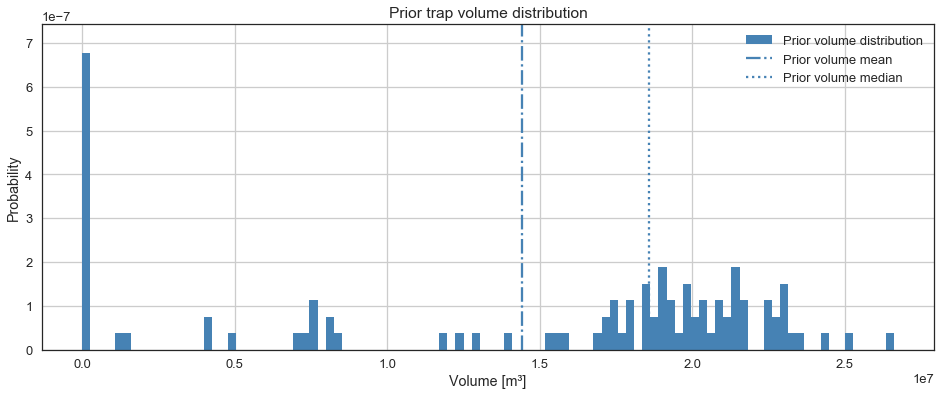

In [31]:
figsize(16, 6)

# Possibly mask away complete failures:
#volumes = max_volume_trace
#mask = volumes == 0
#masked_trace = volumes[~mask]

_hist1 = plt.hist(max_volume_trace, bins=100, normed=True, 
                  histtype="stepfilled",label="Prior volume distribution", color = "steelblue")
plt.vlines(max_volume_trace.mean(), 0, 1.1 * np.max(_hist1[0]), label="Prior volume mean", linestyles="-.", color = "steelblue")
plt.vlines(np.median(max_volume_trace), 0, 1.1 * np.max(_hist1[0]), label="Prior volume median", linestyles=":", color = "steelblue")
plt.title("Prior trap volume distribution")
plt.legend(loc="upper right")
#plt.xticks(np.arange(0, np.max(_hist1[0])+1, np.max(_hist1[0])/10))
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist1[0]))
plt.xlabel("Volume [m³]")
plt.ylabel("Probability")

In [21]:
# INFORMATION ENTROPY FUNCTIONS
def compute_prob_lith(lith_blocks):
    """Blocks must be just the lith blocks!"""
    lith_id = np.unique(lith_blocks)
    lith_count = np.zeros_like(lith_blocks[0:len(lith_id)])
    for i, l_id in enumerate(lith_id):
        lith_count[i] = np.sum(lith_blocks == l_id, axis=0)
    lith_prob = lith_count / len(lith_blocks)
    return lith_prob


def calculate_ie_masked(lith_prob):
    ie = np.zeros_like(lith_prob[0])
    for l in lith_prob:
        pm = np.ma.masked_equal(l, 0)  # mask where layer prob is 0
        ie -= (pm * np.ma.log2(pm)).filled(0)
    return ie


def calculate_ie_total(ie, absolute=False):
    if absolute:
        return np.sum(ie)
    else:
        return np.sum(ie) / np.size(ie)

In [36]:
#CUSTOM LOSS FUNCTION
estimates_s = np.arange(0,60000000, 10000)

# weight factors
ov = 1.25
ov_b = 2
uv_b = 1.5

# risk factor range
risks_s = np.arange(0.5, 1.6, 0.25)

# cutom loss fucntion including risk factors
def volume_lossR(estimate_s, true_s, risk_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s == 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s == 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*(uv_b*(risk_s**-0.5))
        loss_s[overest] = (estimate_s - true_s[overest])*(ov*risk_s)
        loss_s[overest_bad] = np.abs((true_s[overest_bad]-estimate_s))*(ov_b*risk_s)
        return loss_s

Bayes action (minimum) at risk r 0.50: 19048000.00 --- expected loss: 5855210.00
Bayes action (minimum) at risk r 0.75: 17920000.00 --- expected loss: 8183920.00
Bayes action (minimum) at risk r 1.00: 16792000.00 --- expected loss: 10300800.00
Bayes action (minimum) at risk r 1.25: 12400000.00 --- expected loss: 11980835.00
Bayes action (minimum) at risk r 1.50: 7712000.00 --- expected loss: 12946380.00


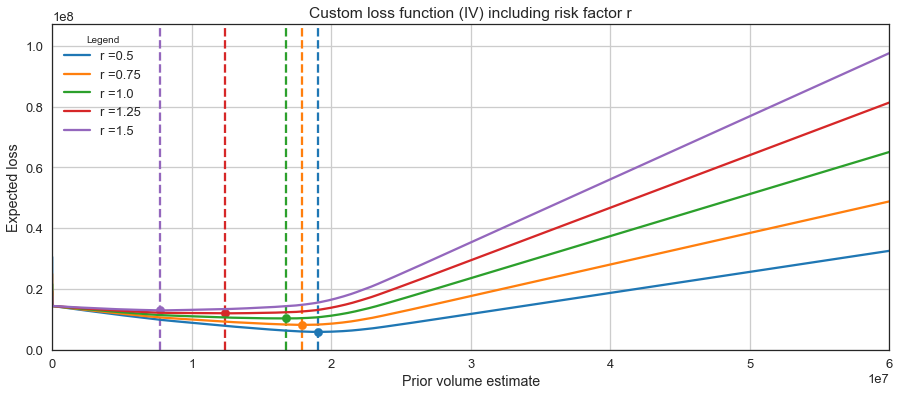

In [36]:
figsize(15, 6)

ax = plt.subplot(111)
expected_loss_s = lambda estimate_s, risk_s: volume_lossR(estimate_s, max_volume_trace, risk_s).mean()

for r in risks_s:
    _color = next(ax._get_lines.prop_cycler)
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _min_vol = sop.fmin(expected_loss_s, -40, args=(r,),disp = False)
    if _min_vol < 0:
        _min_vol = 0
    plt.plot(estimates_s, loss, label = "r ="+str(r), color=_color['color'])
    plt.scatter(_min_vol, expected_loss_s(_min_vol,r), s = 70, color=_color['color'])#, label = "Bayes action r "+str(r))
    plt.vlines(_min_vol, 0, 10 * np.max(loss), color=_color['color'], linestyles="--")
    print("Bayes action (minimum) at risk r %.2f: %.2f --- expected loss: %.2f" % (r, _min_vol,\
                                                                              expected_loss_s(_min_vol,r)))
    
plt.title("""Custom loss function including risk factor r""")    
plt.legend(loc="upper left", scatterpoints=1, title="Legend")
plt.xlabel("Prior volume estimate")
plt.ylabel("Expected loss")
plt.xlim(estimates_s[0], estimates_s[-1])
plt.ylim(0,1.1 * np.max(loss))
plt.grid()

In [22]:
### LIKELIHOOD FUNCTIONS

# THICKNESS LIKELIHOODS
#Additional information, updating with likelihoods
std1 = 30
std2 = 30
std3 = 30

@pymc.stochastic
def sec_res_th_likelihood(value = 0, sec_res_th=sec_res_th):
    return pymc.normal_like(sec_res_th, 150., 1./np.square(std1))

@pymc.stochastic
def seal_th_likelihood(value = 0, seal_th=seal_th):
    return pymc.normal_like(seal_th, 350., 1./np.square(std2))

@pymc.stochastic
def res_th_likelihood(value = 0, res_th=res_th):
    return pymc.normal_like(res_th, 250., 1./np.square(std3))


# SSF LIKELIHOOD
@pymc.stochastic
def SSF_likelihood(value = 0, SSF=structural_model[1]):
    return pymc.normal_like(SSF, 3, 1./np.square(0.3))


# JUXTAPOSITION AREA LIKELIHOOD (MOT USED)
#jux_mean = 150000
#jux_std = jux_mean/4
#
#@pymc.stochastic
#def jux_area_likelihood(value = 0, oja= over_jux_area):
#    return pymc.normal_like(over_jux_area, 150000., 1/np.square(jux_std))

In [23]:
likelihoods = "thickness" # choose which likelihoods to use: "thickness", "SSF" or "both"

if likelihoods == "thickness":
    # Model inclucing only thickness likelihoods
    model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                        fault_sealing, structural_model, 
                        res_th, seal_th, sec_res_th, res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])
elif likelihoods == "SSF":    
    # Model including only SSF likelihood
    model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                        fault_sealing, structural_model, 
                        res_th, seal_th, sec_res_th, SSF_likelihood])
elif likelihoods == "both":
    model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                        fault_sealing, structural_model, 
                        res_th, seal_th, sec_res_th, res_th_likelihood, seal_th_likelihood, 
                          sec_res_th_likelihood, SSF_likelihood])
else:
    print("Did not understand which likelihood functions to use.")

In [24]:
iterations=100

In [25]:
M_L = pymc.MCMC(model_L)
#M_L = pymc.MCMC(model_L,db= "hdf5" , dbname= "D:/PyMC_DataBase/post_model_300_30-050_10-400_40_1000iter50burn.hdf5")
M_L.sample(iter=iterations, burn=50)

Z variations top to bottom: -24.7346472507 16.0557888969 202.635622671 -107.830096519
Fault offset variation: -303.598241568


C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


SPILL POINT AT: [ 1434.34338379   909.09088135  1043.42594963]
LEAK POINT AT: [ 484.84848022  787.87878418  826.41470705]
NUMBER OF TRAPS 2
Checking Section: 109
Stratigraphic adjacency, leakage assumed!
Checking Section: 186
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -49.5797825331 16.0557888969 202.635622671 -107.830096519
Fault offset variation: -303.598241568
SPILL POINT AT: [ 1454.54541016   888.88891602  1044.12838173]
LEAK POINT AT: [ 484.84848022  767.67675781  828.07180111]
NUMBER OF TRAPS 2
Checking Section: 93
Stratigraphic adjacency, leakage assumed!
Checking Section: 157
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: [ 1454.54541016   888.88891602  1044.12838173]
LEAK POINT AT: [ 484.84848022  767.67675781  828.07180111]
NUMBER OF TRAPS 2
Checking Section: 93
Stratigraphic adjacency, leakage assumed!
Checking Section: 157
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -49.5797825331 16.0557888969 -26.

NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
Adding 220.0 to throw, adjacency between 8 and 6
Adding 220.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [784.44840727455608] / [124.44840727455608] = [6.3034025461163088]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -57.0302239938 5.49270253883 -44.4014904802 53.9024955249
Fault offset variation: -372.373067166
SPILL POINT AT: [ 1353.53540039   949.49493408   798.41994054]
LEAK POINT AT: [ 545.45452881  949.49493408  491.9202158 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
Adding 220.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [729.89419301900034] / [249.89419301900034] = [2.9208129416736943]
SSF in confidence range, com

Z variations top to bottom: -57.0302239938 36.4277714721 -44.4014904802 -113.045700221
Fault offset variation: -211.636013918
SPILL POINT AT: [ 1353.53540039   929.29290771   798.47730731]
LEAK POINT AT: [ 585.85858154  949.49493408  622.96218876]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [320.82926195229766] / [280.82926195229766] = [1.1424352993770091]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25096000.0 m³
 [                  2%                  ] 6 of 250 complete in 284.2 secZ variations top to bottom: -57.0302239938 36.4277714721 -44.4014904802 -113.045700221
Fault offset variation: -369.510493823
SPILL POINT AT: [ 1353.53540039   949.49493408   798.32542713]
LEAK POINT AT: [ 545.45452881  949.49493408  492.61764073]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
Adding 100.0 to t

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 40.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [231.05859602920691] / [191.05859602920691] = [1.2093598552031926]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21464000.0 m³
Z variations top to bottom: -68.8629271677 66.1752142107 366.305070316 -46.9812779047
Fault offset variation: -101.710971182
SPILL POINT AT: [ 1373.73742676   929.29290771  1106.29434417]
LEAK POINT AT: [  505.05050659   727.27270508  1083.70274141]
NUMBER OF TRAPS 2
Checking Section: 12
No JP with any layer over seal.
TRAP: 12
Checking Section: 13
Maximum trap volume: 10560000.0 m³
Z variations top to bottom: -68.8629271677 66.1752142107 75.1166181815 31.8596421386
Fault offset variation: -101.710971182
SPILL POINT AT: [ 1373.73742676   929.29290771   917.4767493 ]
LEAK POINT AT: [ 646.4

SPILL POINT AT: [ 1373.73742676   929.29290771   859.10002428]
LEAK POINT AT: [ 666.66668701  949.49493408  847.15640274]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [178.51907768357978] / [158.51907768357978] = [1.1261677792493976]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23232000.0 m³
Z variations top to bottom: -57.8639651813 -24.9370876468 16.5438346696 109.318605255
Fault offset variation: -26.4034866946
SPILL POINT AT: [ 1373.73742676   929.29290771   859.08032732]
LEAK POINT AT: [ 666.66668701  949.49493408  847.43911954]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [178.51907768357978] / [158.51907768357978] = [1.1261677792493976]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

 [--                6%                  ] 16 of 250 complete in 800.4 secZ variations top to bottom: 8.23134028687 -35.8710652863 -2.01110695772 -79.2331215152
Fault offset variation: -67.9331751937
SPILL POINT AT: [ 1373.73742676   929.29290771   840.87734766]
LEAK POINT AT: [ 646.46466064  949.49493408  794.18038487]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [206.1400416714207] / [166.1400416714207] = [1.2407607437532067]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18088000.0 m³
Z variations top to bottom: 4.26805591212 -35.8710652863 -2.01110695772 -79.2331215152
Fault offset variation: -67.9331751937
SPILL POINT AT: [ 1373.73742676   929.29290771   840.89639485]
LEAK POINT AT: [ 646.46466064  949.49493408  794.20495226]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over 

SPILL POINT AT: [ 1373.73742676   949.49493408   890.86631443]
LEAK POINT AT: [ 606.06060791  949.49493408  675.66357391]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
Adding 160.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [554.85644762507354] / [114.85644762507354] = [4.8308689594535794]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 1.37177795171 -36.3072384738 48.8363139011 -175.895747352
Fault offset variation: -252.83000075
SPILL POINT AT: [ 1373.73742676   929.29290771   891.11784149]
LEAK POINT AT: [ 606.06060791  949.49493408  670.32524847]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 260.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [394.85644762507354] / [1

 [---               8%                  ] 21 of 250 complete in 1044.8 secZ variations top to bottom: 35.7143820287 -37.4294351153 48.8363139011 -104.798750202
Fault offset variation: 60.8903553317
SPILL POINT AT: [ 1373.73742676   929.29290771   891.40816719]
LEAK POINT AT: [ 707.07067871  969.69696045  971.0056141 ]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 3552000.0 m³
Z variations top to bottom: 27.3597489016 -37.4294351153 48.8363139011 -104.798750202
Fault offset variation: 60.8903553317
SPILL POINT AT: [ 1373.73742676   929.29290771   891.42357612]
LEAK POINT AT: [ 707.07067871  969.69696045  970.9999121 ]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 3552000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   891.42357612]
LEAK POINT AT: [ 707.07067871  969.69696045  970.9999121 ]
NUMBER OF TRAPS 2
Checking Section: 11
No 

NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [259.75141203195813] / [139.75141203195813] = [1.858667531549224]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21480000.0 m³
Z variations top to bottom: 27.3597489016 -64.5931004413 -11.548041409 102.795311273
Fault offset variation: -126.340623585
SPILL POINT AT: [ 1353.53540039   949.49493408   831.10437269]
LEAK POINT AT: [ 626.26263428  949.49493408  726.61006973]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [266.95494096772109] / [146.95494096772109] = [1.8165768310325694]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21480000.0 m³
 [---               9%                  ] 24 of 250 complete in 1192.1 secZ variations top to botto

SPILL POINT AT: [ 1353.53540039   949.49493408   830.78626109]
LEAK POINT AT: [ 565.65655518  949.49493408  568.94830661]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 180.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
Adding 260.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [588.76650266995216] / [128.76650266995216] = [4.5723576431911717]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -11.6216625348 -82.781538739 -11.548041409 95.9934530685
Fault offset variation: -313.850056684
SPILL POINT AT: [ 1353.53540039   949.49493408   830.77881973]
LEAK POINT AT: [ 565.65655518  949.49493408  569.02475391]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 180.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
Adding 260.0 to throw, adjacency between 7 and 5
JP with layer over se

SPILL POINT AT: [ 1353.53540039   949.49493408   830.7892644 ]
LEAK POINT AT: [ 565.65655518  949.49493408  578.26336056]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 260.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [576.23671603554658] / [116.23671603554658] = [4.9574414667679232]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: [ 1353.53540039   949.49493408   830.7892644 ]
LEAK POINT AT: [ 565.65655518  949.49493408  578.26336056]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 260.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [576.23671603554658] / [116.236716035546

SPILL POINT AT: [ 1353.53540039   949.49493408   830.68343383]
LEAK POINT AT: [ 565.65655518  949.49493408  587.37250412]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
Adding 80.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [366.02136798907236] / [106.02136798907236] = [3.4523358350441038]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -3.08965801905 -105.52667342 -43.5074213568 55.8891301724
Fault offset variation: -295.295098588
SPILL POINT AT: [ 1353.53540039   949.49493408   799.19017956]
LEAK POINT AT: [ 565.65655518  949.49493408  556.60045056]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
Adding 280.0 to throw, adjacency between

SPILL POINT AT: [ 1353.53540039   949.49493408   799.1063626 ]
LEAK POINT AT: [ 565.65655518  949.49493408  551.04679294]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
Adding 280.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [564.99751240807177] / [124.99751240807177] = [4.5200700519827848]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -2.16044621631 -118.509908949 312.41329728 55.8891301724
Fault offset variation: -304.123787026
SPILL POINT AT: [ 1373.73742676   949.49493408   922.75796555]
LEAK POINT AT: [ 505.05050659  606.06060791  752.1711499 ]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 29600000.0 m³
Z

SPILL POINT AT: [ 1353.53540039   929.29290771   774.44292204]
LEAK POINT AT: [ 565.65655518  949.49493408  593.31216521]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 180.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [349.97672855521591] / [169.97672855521591] = [2.0589684925105973]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24696000.0 m³
Z variations top to bottom: -34.2990861481 -102.634595632 -68.6659506739 -66.1610138123
Fault offset variation: -222.568314594
SPILL POINT AT: [ 1353.53540039   929.29290771   774.4324312 ]
LEAK POINT AT: [ 565.65655518  949.49493408  593.22516969]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 180.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [346.03135504196302] / [166.03135504196302] = [2.0841325721548589]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum 

NUMBER OF TRAPS 2
Checking Section: 13
No JP with any layer over seal.
TRAP: 13
Checking Section: 15
Maximum trap volume: 23248000.0 m³
Z variations top to bottom: -13.8756881707 -96.4266048201 -21.7593729547 -78.3825535324
Fault offset variation: -213.105080852
SPILL POINT AT: [ 1353.53540039   949.49493408   820.77942644]
LEAK POINT AT: [ 585.85858154  949.49493408  638.20450385]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [325.33276813462248] / [125.33276813462248] = [2.5957518769965722]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19064000.0 m³
SPILL POINT AT: [ 1353.53540039   949.49493408   820.77942644]
LEAK POINT AT: [ 585.85858154  949.49493408  638.20450385]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [325.33276813462248] / [125.3327

SPILL POINT AT: [ 1353.53540039   929.29290771   820.9293401 ]
LEAK POINT AT: [ 626.26263428  949.49493408  728.66476285]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [273.22286215373083] / [133.22286215373083] = [2.0508706819288176]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19088000.0 m³
Z variations top to bottom: 30.0112278985 -76.3105731767 -21.7593729547 -47.5630934234
Fault offset variation: -115.141765618
SPILL POINT AT: [ 1353.53540039   929.29290771   821.04644405]
LEAK POINT AT: [ 626.26263428  949.49493408  726.60197933]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [265.44879977805431] / [145.44879977805431] = [1.8250325900462048]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum t

 [------           17%                  ] 43 of 250 complete in 2145.1 secZ variations top to bottom: -8.68767515013 -92.2211424055 116.973807272 1.65333478796
Fault offset variation: -104.743394373
SPILL POINT AT: [ 1393.93945312   949.49493408   948.84884125]
LEAK POINT AT: [ 666.66668701  949.49493408  876.93197193]
NUMBER OF TRAPS 2
Checking Section: 17
Stratigraphic adjacency, leakage assumed!
Checking Section: 22
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 40.8534994305 -92.2211424055 116.973807272 1.65333478796
Fault offset variation: -104.743394373
SPILL POINT AT: [ 1373.73742676   949.49493408   948.84131667]
LEAK POINT AT: [ 666.66668701  949.49493408  877.21859211]
NUMBER OF TRAPS 2
Checking Section: 16
Stratigraphic adjacency, leakage assumed!
Checking Section: 20
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: [ 1373.73742676   949.49493408   948.84131667]
LEAK POINT AT: [ 666.66668701  949.49493408  877.21859211]
NUMBER OF TRAPS

SPILL POINT AT: [ 1373.73742676   929.29290771   958.70544157]
LEAK POINT AT: [ 686.86871338  969.69696045  918.57574007]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [201.39187056260084] / [61.391870562600843] = [3.280432225260884]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           18%                  ] 46 of 250 complete in 2292.7 secZ variations top to bottom: 9.58339698338 -21.6343221655 116.973807272 -125.901803308
Fault offset variation: -113.63687321
SPILL POINT AT: [ 1393.93945312   929.29290771   958.56982324]
LEAK POINT AT: [ 666.66668701  949.49493408  864.55227172]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [261.39187056260084] / [61.391870562600843] = [4.2577603218012632]
SSF threshold exceeded, shale 

SPILL POINT AT: [ 1353.53540039   929.29290771   788.19506458]
LEAK POINT AT: [ 565.65655518  949.49493408  553.89873274]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [381.67767002701112] / [221.67767002701112] = [1.7217686832440282]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21928000.0 m³
Z variations top to bottom: -10.9181313036 -32.982908119 202.396564078 -125.901803308
Fault offset variation: -283.336171249
SPILL POINT AT: [ 1434.34338379   888.88891602  1008.58262339]
LEAK POINT AT: [ 484.84848022  747.47473145  807.9433465 ]
NUMBER OF TRAPS 2
Checking Section: 12
Stratigraphic adjacency, leakage assumed!
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -10.9181313036 -32.982908119 -54.660578146 -69.7995064925
Fault offset variation: -283.336171249
SPILL POINT AT: [ 1353.5354003

SPILL POINT AT: [ 1353.53540039   929.29290771   823.25090892]
LEAK POINT AT: [ 626.26263428  949.49493408  751.93727842]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [243.20268684422649] / [223.20268684422649] = [1.0896046561211785]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19152000.0 m³
 [-------          20%                  ] 51 of 250 complete in 2539.4 secZ variations top to bottom: -10.9181313036 3.50464625824 -19.698040586 -45.4858877073
Fault offset variation: -85.7719440199
SPILL POINT AT: [ 1353.53540039   929.29290771   823.25859766]
LEAK POINT AT: [ 626.26263428  949.49493408  762.67859843]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19152000.0 m³
Z variations top to bottom: 38.4216871532 3.50464625824

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


SPILL POINT AT: [ 1353.53540039   929.29290771   761.20671528]
LEAK POINT AT: [ 565.65655518  949.49493408  568.64440441]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [365.3716821026585] / [305.3716821026585] = [1.1964818728012556]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19936000.0 m³
Z variations top to bottom: -5.11228649171 23.2330958384 -82.1385862642 -7.55293307834
Fault offset variation: -85.7719440199
SPILL POINT AT: [ 1353.53540039   929.29290771   761.33137501]
LEAK POINT AT: [ 606.06060791  949.49493408  710.49675376]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19984000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   761.33137501]
LEAK POINT AT: [ 606.06060791  949.49493408  710.49675376]
NUMBER OF TRAPS 2
Checking Section: 10
No JP wi

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21136000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   764.71689946]
LEAK POINT AT: [ 626.26263428  949.49493408  729.73893646]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21136000.0 m³
Z variations top to bottom: -18.5476248124 -27.4332481632 -214.388672352 6.85870639603
Fault offset variation: -65.988622275
SPILL POINT AT: [ 1373.73742676   929.29290771   631.03384465]
LEAK POINT AT: [ 585.85858154  949.49493408  612.55491482]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18712000.0 m³
Z variations top to bottom: -18.5476248124 -27.4332481632 -78.7974637372 63.4928096552
Fault offset variation: -65.988622275
SPILL POINT AT: [ 1353.53540039   929.29290771   764.75604119]
LEAK POINT AT: [ 626.26263428  949.

SPILL POINT AT: [ 1373.73742676   929.29290771  1015.5206152 ]
LEAK POINT AT: [ 525.25250244  707.07067871  974.2190286 ]
NUMBER OF TRAPS 2
Checking Section: 12
No JP with any layer over seal.
TRAP: 12
Checking Section: 13
Maximum trap volume: 18936000.0 m³
Z variations top to bottom: -42.3180138949 -25.8226702878 -21.542707509 112.454395195
Fault offset variation: -125.009101345
SPILL POINT AT: [ 1373.73742676   949.49493408   821.31544076]
LEAK POINT AT: [ 606.06060791  949.49493408  722.32205989]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [275.72003722114528] / [195.72003722114528] = [1.4087471121293909]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18368000.0 m³
Z variations top to bottom: -42.3180138949 -17.8188248181 -21.542707509 75.1963004522
Fault offset variation: -125.009101345
SPILL POINT AT: [ 1373.73742676   929.29290

SPILL POINT AT: [ 1373.73742676   949.49493408   821.31951998]
LEAK POINT AT: [ 626.26263428  949.49493408  752.99361519]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16888000.0 m³
SPILL POINT AT: [ 1373.73742676   949.49493408   821.31951998]
LEAK POINT AT: [ 626.26263428  949.49493408  752.99361519]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16888000.0 m³
Z variations top to bottom: 16.7147621962 20.2229386055 84.0445580764 161.163691294
Fault offset variation: -89.8356817985
SPILL POINT AT: [ 1373.73742676   949.49493408   925.91399559]
LEAK POINT AT: [ 666.66668701  949.49493408  851.24063183]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [236.17838052902925] / [136.

SPILL POINT AT: [ 1373.73742676   929.29290771   671.02243544]
LEAK POINT AT: [ 565.65655518  949.49493408  590.19285697]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22176000.0 m³
 [---------        25%                  ] 64 of 250 complete in 3171.9 secZ variations top to bottom: 17.7639079891 -24.5632842712 -173.799089851 12.2063517137
Fault offset variation: -238.206055259
SPILL POINT AT: [ 1353.53540039   929.29290771   671.03192235]
LEAK POINT AT: [ 545.45452881  949.49493408  492.78024388]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [369.23580558000594] / [349.23580558000594] = [1.0572678965914857]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22288000.0 m³
Z variations top to bottom: -7.58731093358 -24.5632842712 -173.799089851 12.2063517137
Fault o

NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
Adding 60.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [343.47693321656334] / [23.476933216563339] = [14.630400404011674]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 38.1622834182 -12.6358121546 60.1525663939 91.5070641844
Fault offset variation: -189.35998956
SPILL POINT AT: [ 1373.73742676   949.49493408   902.22878932]
LEAK POINT AT: [ 626.26263428  949.49493408  736.88245835]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [327.21162145145991] / [127.21162145145991] = [2.5721834036705045]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 16744000.0 m³
Z variations top to bottom: 38.1622834182 -12.6358

SPILL POINT AT: [ 1393.93945312   929.29290771   969.17617017]
LEAK POINT AT: [ 626.26263428  949.49493408  783.64763373]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 280.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [387.79805732028376] / [67.79805732028376] = [5.719899251512369]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [----------       27%                  ] 69 of 250 complete in 3422.2 secZ variations top to bottom: 47.8206357051 -4.39456131537 127.807381364 -84.678456417
Fault offset variation: -228.621328473
SPILL POINT AT: [ 1393.93945312   929.29290771   969.15449189]
LEAK POINT AT: [ 626.26263428  949.49493408  769.31154116]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 280.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [3

SPILL POINT AT: [ 1414.14135742   888.88891602  1037.82091034]
LEAK POINT AT: [ 525.25250244  545.45452881  929.01343285]
NUMBER OF TRAPS 2
Checking Section: 12
No JP with any layer over seal.
TRAP: 12
Checking Section: 13
Maximum trap volume: 10008000.0 m³
Z variations top to bottom: 61.4338472794 -3.85780838737 186.745382521 180.747247594
Fault offset variation: -196.93526934
SPILL POINT AT: [ 1373.73742676   949.49493408  1026.88219057]
LEAK POINT AT: [ 666.66668701  949.49493408  863.05434803]
NUMBER OF TRAPS 2
Checking Section: 27
Stratigraphic adjacency, leakage assumed!
Checking Section: 32
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 61.4338472794 -10.4042451091 186.745382521 -84.678456417
Fault offset variation: -196.93526934
SPILL POINT AT: [ 1393.93945312   949.49493408  1026.96622909]
LEAK POINT AT: [ 666.66668701  949.49493408  866.07209544]
NUMBER OF TRAPS 2
Checking Section: 269
Stratigraphic adjacency, leakage assumed!
Checking Section: 482


NUMBER OF TRAPS 2
Checking Section: 11
Adding 340.0 to throw, adjacency between 8 and 5
Adding 220.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [594.1867429896738] / [34.186742989673803] = [17.380618655867554]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 7.1181711222 35.4916721816 185.754484657 -90.6929640563
Fault offset variation: -306.578908977
SPILL POINT AT: [ 1393.93945312   949.49493408  1026.27775788]
LEAK POINT AT: [ 626.26263428  949.49493408  758.79332146]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 320.0 to throw, adjacency between 8 and 5
Adding 220.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [589.7371875248632] / [49.737187524863202] = [11.85706745541369]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [

 [-----------      30%                  ] 77 of 250 complete in 3880.7 secZ variations top to bottom: -5.83959760768 34.7247154831 95.7064103233 -90.6929640563
Fault offset variation: -261.699226823
SPILL POINT AT: [ 1393.93945312   929.29290771   937.71930213]
LEAK POINT AT: [ 606.06060791  949.49493408  707.56871237]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 260.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [499.0183051597885] / [139.0183051597885] = [3.5895870301843615]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -14.7682146713 34.7247154831 95.7064103233 -90.6929640563
Fault offset variation: -261.699226823
SPILL POINT AT: [ 1393.93945312   929.29290771   937.72467283]
LEAK POINT AT: [ 606.06060791  949.49493408  707.79283317]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 260.0 to t

SPILL POINT AT: [ 1373.73742676   949.49493408   879.92224535]
LEAK POINT AT: [ 545.45452881  949.49493408  521.52911432]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 320.0 to throw, adjacency between 8 and 5
Adding 220.0 to throw, adjacency between 8 and 6
Adding 320.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [1025.8537665314973] / [165.85376653149729] = [6.1852907412668099]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 0.398999012654 3.54023557531 417.243207846 45.9202598077
Fault offset variation: -422.399143261
SPILL POINT AT: [ 1454.54541016   848.48486328  1049.56742762]
LEAK POINT AT: [ 161.61616516  969.69696045  838.58985486]
NUMBER OF TRAPS 3
Checking Section: 159
Checking Section: 160
Adding 100.0 to throw, adjacency between 103 and 5
JP with layer over seal, checking SSF.
SSF = [313.70297227057245] / [213.70297227057245] = [

SPILL POINT AT: [ 1393.93945312   949.49493408   935.76891878]
LEAK POINT AT: [ 545.45452881  929.29290771  537.67015043]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
Adding 280.0 to throw, adjacency between 8 and 6
Adding 260.0 to throw, adjacency between 7 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [875.80921148440939] / [115.80921148440939] = [7.5625176983638616]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -47.5239444719 2.32215970469 94.0244817525 44.3872396857
Fault offset variation: -466.288812579
SPILL POINT AT: [ 1393.93945312   949.49493408   935.74304277]
LEAK POINT AT: [ 545.45452881  929.29290771  537.84355947]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
Adding 280.0 to throw, adjacency between 8 and 6
Adding 260.0 to throw, adjace

SPILL POINT AT: [ 1373.73742676   949.49493408   907.42888469]
LEAK POINT AT: [ 565.65655518  949.49493408  600.54833821]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
Adding 160.0 to throw, adjacency between 8 and 6
Adding 280.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [746.91858817992124] / [106.91858817992124] = [6.9858628036035801]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [------------     33%                  ] 84 of 250 complete in 4238.3 secZ variations top to bottom: -30.8026809271 -27.3954216942 65.6859901259 123.619183656
Fault offset variation: -198.838047237
SPILL POINT AT: [ 1373.73742676   949.49493408   907.52222285]
LEAK POINT AT: [ 626.26263428  949.49493408  738.18359323]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 

 [-------------    34%                  ] 86 of 250 complete in 4338.3 secZ variations top to bottom: 0.204073368879 -29.6255652323 65.6859901259 128.310288544
Fault offset variation: -447.481870816
SPILL POINT AT: [ 1373.73742676   949.49493408   907.403105  ]
LEAK POINT AT: [ 545.45452881  929.29290771  527.18432697]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 6
Adding 340.0 to throw, adjacency between 7 and 5
Adding 80.0 to throw, adjacency between 7 and 6
JP with layer over seal, checking SSF.
SSF = [744.68844464177118] / [104.68844464177118] = [7.1133776721011381]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -25.8118362957 -29.6255652323 65.6859901259 128.310288544
Fault offset variation: -198.838047237
SPILL POINT AT: [ 1373.73742676   949.49493408   907.49758918]
LEAK POINT AT: [ 626.26263428  949.49493408  738.402633  ]
NUMBER

SPILL POINT AT: [ 1373.73742676   929.29290771   880.34567312]
LEAK POINT AT: [ 606.06060791  949.49493408  711.99265615]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [329.09671812828992] / [189.09671812828992] = [1.7403618708232633]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16464000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   880.34567312]
LEAK POINT AT: [ 606.06060791  949.49493408  711.99265615]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [329.09671812828992] / [189.09671812828992] = [1.7403618708232633]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16464000.0 m³
Z variations top to bottom: 28.1182895339 27.128814448 -60.444034592 128.310288544
Fault offset vari

SPILL POINT AT: [ 1353.53540039   929.29290771   720.78494058]
LEAK POINT AT: [ 606.06060791  949.49493408  718.27466887]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19896000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   720.78494058]
LEAK POINT AT: [ 606.06060791  949.49493408  718.27466887]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19896000.0 m³
Z variations top to bottom: -30.2633501007 63.9901523453 -162.460041892 32.5909111544
Fault offset variation: -45.0038955974
SPILL POINT AT: [ 1353.53540039   929.29290771   682.14035863]
LEAK POINT AT: [ 606.06060791  949.49493408  679.97322024]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18848000.0 m³
Z variations top to bottom: -30.2633501007 63.9901523453 -123.209335408 103.866813206
Fault offset va

SPILL POINT AT: [ 1373.73742676   949.49493408   959.2282074 ]
LEAK POINT AT: [ 666.66668701  949.49493408  895.57907914]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 120.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [357.10517286657227] / [237.10517286657227] = [1.506104521251961]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 19024000.0 m³
Z variations top to bottom: 20.1970760497 22.6663863216 -10.7487842392 138.457299775
Fault offset variation: -87.4898737093
SPILL POINT AT: [ 1373.73742676   929.29290771   832.06683869]
LEAK POINT AT: [ 626.26263428  949.49493408  765.68631761]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20752000.0 m³
 [--------------   38%                  ] 95 of 250 complete in 4776.7 secZ variations top 

SPILL POINT AT: [ 1353.53540039   929.29290771   842.29666468]
LEAK POINT AT: [ 606.06060791  949.49493408  679.63893717]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [329.59324781195028] / [229.59324781195028] = [1.4355528786365077]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17912000.0 m³
Z variations top to bottom: 21.2846347215 29.1408644075 -0.45238340442 -0.851665031738
Fault offset variation: -192.787408251
SPILL POINT AT: [ 1353.53540039   929.29290771   842.41098378]
LEAK POINT AT: [ 606.06060791  949.49493408  678.51942769]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [329.59324781195028] / [229.59324781195028] = [1.4355528786365077]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum t

NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [334.95077674272261] / [234.95077674272261] = [1.4256210657669059]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18400000.0 m³
 [---------------  40%                  ] 100 of 250 complete in 5022.4 secZ variations top to bottom: 13.7908926069 34.4983933383 -0.45238340442 -133.863140821
Fault offset variation: -366.202157085
SPILL POINT AT: [ 1353.53540039   929.29290771   842.23335931]
LEAK POINT AT: [ 545.45452881  949.49493408  534.02512819]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 260.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [594.95077674272261] / [234.95077674272261] = [2.5322358367608619]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum 

SPILL POINT AT: [ 1393.93945312   929.29290771   973.25556529]
LEAK POINT AT: [ 686.86871338  969.69696045  922.54035466]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [236.15804411003319] / [96.158044110033188] = [2.4559364356433733]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 18888000.0 m³
Z variations top to bottom: -22.9156551969 27.6891525255 131.531108415 -252.398886788
Fault offset variation: -68.9232154223
SPILL POINT AT: [ 1393.93945312   929.29290771   973.37778525]
LEAK POINT AT: [ 686.86871338  969.69696045  926.31173444]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [236.15804411003319] / [96.158044110033188] = [2.4559364356433733]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum tr

SPILL POINT AT: [ 1353.53540039   929.29290771   831.36580701]
LEAK POINT AT: [ 626.26263428  949.49493408  776.17764803]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [218.57668673215358] / [198.57668673215358] = [1.1007167574861223]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21552000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   831.36580701]
LEAK POINT AT: [ 626.26263428  949.49493408  776.17764803]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [218.57668673215358] / [198.57668673215358] = [1.1007167574861223]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21552000.0 m³
Z variations top to bottom: 62.8898924166 -13.0294770165 127.021457604 -13.0776455575
Fault offset var

SPILL POINT AT: [ 1353.53540039   929.29290771   831.31927255]
LEAK POINT AT: []
No res_formation above max_z!
Maximum trap volume: 0 m³
Z variations top to bottom: 46.3698626081 -19.7494179236 -11.6061637486 31.9429115384
Fault offset variation: -77.2368218862
SPILL POINT AT: [ 1353.53540039   929.29290771   831.32578118]
LEAK POINT AT: [ 626.26263428  949.49493408  773.46246819]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [211.85674582505089] / [191.85674582505089] = [1.1042444450623461]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21448000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   831.32578118]
LEAK POINT AT: [ 626.26263428  949.49493408  773.46246819]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [211.85674582505089] / [191.8567458

SPILL POINT AT: [ 1353.53540039   929.29290771   791.8266341 ]
LEAK POINT AT: [ 606.06060791  949.49493408  713.10796786]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22032000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   791.8266341 ]
LEAK POINT AT: [ 606.06060791  949.49493408  713.10796786]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22032000.0 m³
Z variations top to bottom: 90.9047848964 -10.8778715501 -52.713293253 90.4782504629
Fault offset variation: -105.408440878
SPILL POINT AT: [ 1353.53540039   929.29290771   790.50941543]
LEAK POINT AT: [ 606.06060791  949.49493408  712.17408144]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume:

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20968000.0 m³
Z variations top to bottom: 59.1548907983 59.9990188337 -97.4260090402 -49.9508584372
Fault offset variation: -75.0697442408
SPILL POINT AT: [ 1353.53540039   929.29290771   746.16567905]
LEAK POINT AT: [ 606.06060791  949.49493408  710.82435618]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21888000.0 m³
Z variations top to bottom: 59.1548907983 43.5861087055 -97.4260090402 -49.9508584372
Fault offset variation: -75.0697442408
SPILL POINT AT: [ 1353.53540039   929.29290771   746.17503326]
LEAK POINT AT: [ 606.06060791  949.49493408  709.93926085]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21952000.0 m³
 [-----------------48%                  ] 120 of 250 complete in 6019.8 secZ variations top to bot

SPILL POINT AT: [ 1393.93945312   888.88891602  1053.13110811]
LEAK POINT AT: [ 484.84848022  707.07067871  950.04411732]
NUMBER OF TRAPS 2
Checking Section: 12
No JP with any layer over seal.
TRAP: 12
Checking Section: 13
Maximum trap volume: 25224000.0 m³
Z variations top to bottom: -34.4239880611 10.0712036949 17.8158782187 -265.713669387
Fault offset variation: -182.921973741
SPILL POINT AT: [ 1373.73742676   929.29290771   860.55671782]
LEAK POINT AT: [ 606.06060791  949.49493408  710.77918755]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [332.25532547617286] / [192.25532547617286] = [1.7281982938743139]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17768000.0 m³
Z variations top to bottom: -34.4239880611 19.9555627852 17.8158782187 -265.713669387
Fault offset variation: -182.921973741
SPILL POINT AT: [ 1373.73742676   929.2929

SPILL POINT AT: [ 1373.73742676   929.29290771   877.95090317]
LEAK POINT AT: [ 686.86871338  949.49493408  914.18284889]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 10960000.0 m³
 [-----------------50%                  ] 126 of 250 complete in 6303.9 secZ variations top to bottom: -2.42785810173 63.3345612173 35.2100559732 -0.90600516672
Fault offset variation: 205.18362013
SPILL POINT AT: [ 1373.73742676   929.29290771   877.85660766]
LEAK POINT AT: []
No res_formation above max_z!
Maximum trap volume: 0 m³
Z variations top to bottom: 39.6896649928 63.3345612173 35.2100559732 -0.90600516672
Fault offset variation: 9.77294327364
SPILL POINT AT: [ 1373.73742676   929.29290771   877.96560704]
LEAK POINT AT: [ 686.86871338  969.69696045  913.92351692]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 10952000.0 m³
Z variations top to bottom

Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [397.5143611170738] / [237.5143611170738] = [1.6736434767459556]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20568000.0 m³
Z variations top to bottom: 30.771292628 66.0229863716 28.5086252546 -75.4739070214
Fault offset variation: -91.0057917166
SPILL POINT AT: [ 1373.73742676   929.29290771   871.25087604]
LEAK POINT AT: [ 646.46466064  949.49493408  806.17983823]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20440000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   871.25087604]
LEAK POINT AT: [ 646.46466064  949.49493408  806.17983823]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20440000.0 

SPILL POINT AT: [ 1373.73742676   929.29290771   869.05571424]
LEAK POINT AT: [ 606.06060791  949.49493408  684.72800988]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 140.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [350.10969203966783] / [210.10969203966783] = [1.666318619769185]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19904000.0 m³
 [-----------------52%                  ] 132 of 250 complete in 6591.5 secZ variations top to bottom: -11.4030297422 36.5359944988 26.4263024591 -63.6643565156
Fault offset variation: -159.969492464
SPILL POINT AT: [ 1373.73742676   929.29290771   869.11830137]
LEAK POINT AT: [ 626.26263428  949.49493408  734.75947559]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [310.1096920396678

SPILL POINT AT: [ 1353.53540039   929.29290771   762.23438776]
LEAK POINT AT: [ 585.85858154  949.49493408  618.88529491]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [313.38813008231978] / [293.38813008231978] = [1.0681690837130606]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20320000.0 m³
Z variations top to bottom: -4.10502755818 12.2173381943 -81.1707918881 -60.6644957362
Fault offset variation: -182.145984303
SPILL POINT AT: [ 1353.53540039   929.29290771   762.18024691]
LEAK POINT AT: [ 585.85858154  949.49493408  618.90914373]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [313.38813008231978] / [293.38813008231978] = [1.0681690837130606]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tra

NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [350.88729424115877] / [270.88729424115877] = [1.2953257745960562]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19976000.0 m³
Z variations top to bottom: -7.67887547512 -10.2834976469 -81.1707918881 66.842585924
Fault offset variation: -251.260570003
SPILL POINT AT: [ 1353.53540039   929.29290771   762.22182854]
LEAK POINT AT: [ 565.65655518  949.49493408  559.89523999]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [350.88729424115877] / [270.88729424115877] = [1.2953257745960562]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19984000.0 m³
SPILL POINT AT: [ 135

SPILL POINT AT: [ 1373.73742676   949.49493408   914.81488205]
LEAK POINT AT: [ 606.06060791  949.49493408  676.28816853]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [648.55806236926492] / [128.55806236926492] = [5.0448649459757204]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -31.3944289369 1.52647100658 81.6905374982 121.057519084
Fault offset variation: -281.088257985
SPILL POINT AT: [ 1373.73742676   949.49493408   923.46356036]
LEAK POINT AT: [ 606.06060791  949.49493408  681.98667512]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
Adding 220.0 to throw, adjacency between 7 and 5
JP with layer over 

SPILL POINT AT: [ 1373.73742676   929.29290771   876.71106792]
LEAK POINT AT: [ 646.46466064  949.49493408  799.12908565]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [244.89712751301272] / [204.89712751301272] = [1.1952199158939387]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22064000.0 m³
Z variations top to bottom: -29.9184582026 39.0074885171 -55.8332614198 32.9958670057
Fault offset variation: -96.1751931521
SPILL POINT AT: [ 1353.53540039   929.29290771   787.33784854]
LEAK POINT AT: [ 606.06060791  949.49493408  724.18156371]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21008000.0 m³
Z variations top to bottom: -29.9184582026 39.0074885171 -55.8332614198 -7.22254078997
Fault offset variation: -96.1751931521
SPILL POINT AT: [ 1353.53540039   929.2929

SPILL POINT AT: [ 1373.73742676   929.29290771   943.41764035]
LEAK POINT AT: []
No res_formation above max_z!
Maximum trap volume: 0 m³
Z variations top to bottom: -21.0427483896 31.3895250542 101.409625439 81.8596141046
Fault offset variation: -96.1751931521
SPILL POINT AT: [ 1393.93945312   929.29290771   943.33753294]
LEAK POINT AT: [ 666.66668701  949.49493408  859.9008073 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [209.9798996149425] / [129.9798996149425] = [1.6154797798505394]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 16144000.0 m³
SPILL POINT AT: [ 1393.93945312   929.29290771   943.33753294]
LEAK POINT AT: [ 666.66668701  949.49493408  859.9008073 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [209.9798996149425] / [129.97989961494

 [-----------------59%--                ] 148 of 250 complete in 7372.6 secZ variations top to bottom: -4.90299764908 65.2317264697 95.8993738355 -45.9292887327
Fault offset variation: -167.756018722
SPILL POINT AT: [ 1393.93945312   929.29290771   938.06438904]
LEAK POINT AT: [ 646.46466064  949.49493408  794.72551601]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [309.33235263424422] / [169.33235263424422] = [1.8267764418439179]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21392000.0 m³
Z variations top to bottom: -9.30111896581 65.2317264697 95.8993738355 -45.9292887327
Fault offset variation: -167.756018722
SPILL POINT AT: [ 1393.93945312   929.29290771   938.06446993]
LEAK POINT AT: [ 646.46466064  949.49493408  794.75545865]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to 

NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [111.75214209399473] / [71.752142093994735] = [1.5574746458105784]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 10856000.0 m³
Z variations top to bottom: 49.2407169884 -6.67503638526 166.274118456 -103.599354127
Fault offset variation: 15.188264195
SPILL POINT AT: [ 1373.73742676   949.49493408  1007.24114593]
LEAK POINT AT: [  727.27270508   969.69696045  1038.37507165]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [127.05084515830504] / [27.050845158305037] = [4.6967421688596822]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------60%--                ] 151 of 250 complete in 7517.4 secZ variations top to b

NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [128.93141664146788] / [28.931416641467877] = [4.4564501710804008]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: [ 1393.93945312   949.49493408  1007.09630081]
LEAK POINT AT: [  727.27270508   969.69696045  1048.65481396]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [128.93141664146788] / [28.931416641467877] = [4.4564501710804008]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 65.9295245636 -4.7944649021 69.7458576575 79.2151826678
Fault offset variation: 30.7115404734
SPILL POINT AT: [ 1373.73742676   929.29290771   911.96964397]
LEAK POINT AT: [ 686.86871338  9

SPILL POINT AT: [ 1373.73742676   929.29290771   885.48442232]
LEAK POINT AT: [ 686.86871338  969.69696045  936.24226001]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8520000.0 m³
 [-----------------62%---               ] 157 of 250 complete in 7807.4 secZ variations top to bottom: 21.1525176797 13.7157238905 42.7799963141 -30.3901609247
Fault offset variation: 278.081190431
SPILL POINT AT: [ 1373.73742676   929.29290771   885.32717514]
LEAK POINT AT: []
No res_formation above max_z!
Maximum trap volume: 0 m³
Z variations top to bottom: 15.984537276 13.7157238905 42.7799963141 -30.3901609247
Fault offset variation: 30.7115404734
SPILL POINT AT: [ 1373.73742676   929.29290771   885.48123499]
LEAK POINT AT: [ 686.86871338  969.69696045  936.26965414]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8520000.0 m³
SPILL POINT AT: [ 1373.737426

Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [454.95091312203135] / [234.95091312203135] = [1.9363658011651737]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24120000.0 m³
Z variations top to bottom: 17.4021189115 9.14635651379 -25.8045566082 -47.9292770512
Fault offset variation: -165.15916195
SPILL POINT AT: [ 1353.53540039   929.29290771   817.12369828]
LEAK POINT AT: [ 606.06060791  949.49493408  679.87630818]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [334.95091312203135] / [234.95091312203135] = [1.4256208187114425]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24064000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   817.12369828]
LEAK POINT AT: [ 606.06060791  949.49493408  679.87630818]
NUMBER OF TRAPS 2
Checkin

SPILL POINT AT: [ 1353.53540039   949.49493408   816.79996358]
LEAK POINT AT: [ 565.65655518  949.49493408  554.74517626]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 280.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [455.37852006399567] / [175.37852006399567] = [2.5965467144883418]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24464000.0 m³
Z variations top to bottom: 22.4929061903 -48.8108314177 -25.8045566082 -47.9292770512
Fault offset variation: -311.006820001
SPILL POINT AT: [ 1353.53540039   949.49493408   816.86455905]
LEAK POINT AT: [ 565.65655518  949.49493408  556.03923369]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 280.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
Unable to calculate an adjacency area.
JP with layer over 

SPILL POINT AT: [ 1373.73742676   929.29290771   889.53462263]
LEAK POINT AT: [ 666.66668701  969.69696045  881.60526788]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [137.74607490315816] / [117.74607490315816] = [1.1698570420835621]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19560000.0 m³
Z variations top to bottom: -78.3507251339 -34.9965823332 47.2573427636 87.2567500655
Fault offset variation: -20.1707375411
SPILL POINT AT: [ 1373.73742676   949.49493408   889.44239358]
LEAK POINT AT: [ 666.66668701  949.49493408  879.49261589]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [137.74607490315816] / [117.74607490315816] = [1.1698570420835621]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

NUMBER OF TRAPS 2
Checking Section: 314
Stratigraphic adjacency, leakage assumed!
Checking Section: 597
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 10.5593526669 -45.4847030925 167.62757764 81.3824002784
Fault offset variation: 62.0869533248
SPILL POINT AT: [ 1393.93945312   949.49493408   995.19978128]
LEAK POINT AT: [  727.27270508   969.69696045  1074.45056404]
NUMBER OF TRAPS 2
Checking Section: 12
Stratigraphic adjacency, leakage assumed!
Checking Section: 14
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------69%------            ] 173 of 250 complete in 8618.7 secZ variations top to bottom: 10.5593526669 -45.4847030925 167.62757764 81.3824002784
Fault offset variation: -48.3881726094
SPILL POINT AT: [ 1393.93945312   949.49493408   995.08553735]
LEAK POINT AT: [ 707.07067871  969.69696045  973.95429703]
NUMBER OF TRAPS 2
Checking Section: 12
Stratigraphic adjacency, leakage assumed!
Checking Section: 14
No trap found! =(
Maximum trap vo

NUMBER OF TRAPS 2
Checking Section: 11
Adding 280.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [422.25513473528008] / [42.25513473528008] = [9.9929899024254354]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: [ 1393.93945312   949.49493408   969.51317717]
LEAK POINT AT: [ 646.46466064  949.49493408  799.53666012]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 280.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [422.25513473528008] / [42.25513473528008] = [9.9929899024254354]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 2.69388662489 -29.2987589926 -105.44312143 66.2424515361
Fault offset variation: -202.575648715


SPILL POINT AT: [ 1353.53540039   949.49493408   770.59189894]
LEAK POINT AT: [ 545.45452881  949.49493408  491.60817865]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 220.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [620.76038153590412] / [260.76038153590412] = [2.3805778235158455]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22744000.0 m³
Z variations top to bottom: 36.9841186231 -32.3047852852 -72.5868997853 56.5623452402
Fault offset variation: -342.984580379
SPILL POINT AT: [ 1353.53540039   929.29290771   770.61433824]
LEAK POINT AT: [ 545.45452881  949.49493408  491.49943616]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 220.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [600.28211450013828] / [240.28211450013828] = [2.4982388545602414]
SSF i

SPILL POINT AT: [ 1393.93945312   949.49493408   943.78518277]
LEAK POINT AT: [ 585.85858154  929.29290771  615.71594883]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 340.0 to throw, adjacency between 8 and 5
Adding 180.0 to throw, adjacency between 8 and 6
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [780.91358062616791] / [60.913580626167914] = [12.820024247444987]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------72%-------           ] 180 of 250 complete in 8967.8 secZ variations top to bottom: 22.5300145737 -17.6276462352 102.359382601 -8.99373467617
Fault offset variation: -254.510632889
SPILL POINT AT: [ 1393.93945312   949.49493408   943.9679945 ]
LEAK POINT AT: [ 606.06060791  949.49493408  724.81129562]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 300.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8

SPILL POINT AT: [ 1373.73742676   929.29290771   933.07141886]
LEAK POINT AT: [ 626.26263428  949.49493408  750.52953577]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [364.33552236312676] / [104.33552236312676] = [3.4919604954399182]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   933.07141886]
LEAK POINT AT: [ 626.26263428  949.49493408  750.52953577]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [364.33552236312676] / [104.33552236312676] = [3.4919604954399182]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z 

SPILL POINT AT: [ 1373.73742676   929.29290771   971.95844027]
LEAK POINT AT: [ 686.86871338  969.69696045  967.27994111]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [190.49814466231578] / [50.498144662315781] = [3.7723790831561965]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 31.3910843384 -19.0677747307 88.3214531086 -123.845336693
Fault offset variation: -23.6702972682
SPILL POINT AT: [ 1393.93945312   929.29290771   930.61021194]
LEAK POINT AT: [ 686.86871338  969.69696045  921.72286856]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [192.61077216076842] / [92.61077216076842] = [2.0797879951416904]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum tr

SPILL POINT AT: [ 1353.53540039   929.29290771   793.9650853 ]
LEAK POINT AT: [ 646.46466064  949.49493408  798.31922441]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23472000.0 m³
 [-----------------75%--------          ] 188 of 250 complete in 9359.4 secZ variations top to bottom: 2.63030697781 -20.9047524261 -49.1909561588 -58.3727559512
Fault offset variation: 59.7991697219
SPILL POINT AT: [ 1353.53540039   929.29290771   794.05234464]
LEAK POINT AT: [ 666.66668701  969.69696045  886.78355805]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 2760000.0 m³
Z variations top to bottom: 21.9376667335 -20.9047524261 -49.1909561588 -58.3727559512
Fault offset variation: 59.7991697219
SPILL POINT AT: [ 1353.53540039   929.29290771   794.05936215]
LEAK POINT AT: [ 666.66668701  969.69696045  886.65277629]
NUMBER OF TRAPS 2
Checking Section: 10

SPILL POINT AT: [ 1353.53540039   929.29290771   667.43858709]
LEAK POINT AT: [ 585.85858154  949.49493408  605.94256146]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24288000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   667.43858709]
LEAK POINT AT: [ 585.85858154  949.49493408  605.94256146]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24288000.0 m³
Z variations top to bottom: -40.5673365378 9.46241358554 -350.005380118 -91.1052588734
Fault offset variation: -109.928105483
SPILL POINT AT: [ 1373.73742676   929.29290771   497.27973842]
LEAK POINT AT: [ 525.25250244  949.49493408  451.45401394]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 13632000.0 m³
Z variations top to bottom: -40.5673365378 9.46241358554 -177.356978229 -187.540661123
Fault offset 

SPILL POINT AT: [ 1393.93945312   949.49493408  1038.25013832]
LEAK POINT AT: [ 666.66668701  949.49493408  907.13192992]
NUMBER OF TRAPS 2
Checking Section: 127
Stratigraphic adjacency, leakage assumed!
Checking Section: 199
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 9.4692826259 4.36497923896 412.080722531 -91.1052588734
Fault offset variation: -166.286745399
SPILL POINT AT: [ 1393.93945312   909.09088135  1045.62045128]
LEAK POINT AT: [ 505.05050659  646.46466064  963.58240592]
NUMBER OF TRAPS 2
Checking Section: 301
No JP with any layer over seal.
TRAP: 301
Checking Section: 531
Maximum trap volume: 8936000.0 m³
Z variations top to bottom: 9.4692826259 4.36497923896 198.105791841 -49.3639821258
Fault offset variation: -166.286745399
SPILL POINT AT: [ 1393.93945312   949.49493408  1038.2244389 ]
LEAK POINT AT: [ 666.66668701  949.49493408  906.60337076]
NUMBER OF TRAPS 2
Checking Section: 134
Stratigraphic adjacency, leakage assumed!
Checking Section: 

Adding 100.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [506.77776482198828] / [66.777764821988285] = [7.5890195811872809]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: 24.8022869766 -13.7467034381 447.845697446 -49.3639821258
Fault offset variation: -285.602413402
SPILL POINT AT: [ 1414.14135742   888.88891602  1029.13324195]
LEAK POINT AT: [ 464.64645386  525.25250244  861.7327955 ]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 20928000.0 m³
Z variations top to bottom: 24.8022869766 -13.7467034381 119.47553174 212.738221707
Fault offset variation: -285.602413402
SPILL POINT AT: [ 1373.73742676   949.49493408   960.45230108]
LEAK POINT AT: [ 606.06060791  949.49493408  721.84040992]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 

SPILL POINT AT: [ 1393.93945312   929.29290771   923.43698422]
LEAK POINT AT: [ 686.86871338  969.69696045  917.97311732]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [176.49882529279284] / [136.49882529279284] = [1.2930428149414412]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 16792000.0 m³
Z variations top to bottom: -6.38107491406 17.4893900773 80.9905647845 -21.7977422602
Fault offset variation: -23.6383363837
SPILL POINT AT: [ 1393.93945312   929.29290771   923.3915024 ]
LEAK POINT AT: [ 686.86871338  969.69696045  916.88907324]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [176.49882529279284] / [136.49882529279284] = [1.2930428149414412]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap

SPILL POINT AT: [ 1373.73742676   929.29290771   915.39369025]
LEAK POINT AT: [ 646.46466064  949.49493408  818.91258056]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [264.70393922781864] / [184.70393922781864] = [1.4331255756344532]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20768000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   915.39369025]
LEAK POINT AT: [ 646.46466064  949.49493408  818.91258056]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [264.70393922781864] / [184.70393922781864] = [1.4331255756344532]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20768000.0 m³
Z variations top to bottom: -16.1303075624 57.6342104277 -16.1400331885 -23.7050185968
Fault offset va

SPILL POINT AT: [ 1373.73742676   929.29290771   905.15610723]
LEAK POINT AT: [ 646.46466064  949.49493408  805.26642116]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [261.72381867810486] / [161.72381867810486] = [1.6183381076292789]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17600000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   905.15610723]
LEAK POINT AT: [ 646.46466064  949.49493408  805.26642116]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [261.72381867810486] / [161.72381867810486] = [1.6183381076292789]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17600000.0 m³
Z variations top to bottom: 2.53816600234 24.401863927 354.329316961 -23.7050185968
Fault offset var

SPILL POINT AT: [ 1393.93945312   929.29290771   921.75054977]
LEAK POINT AT: [ 646.46466064  949.49493408  832.14253872]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [282.07342193698219] / [142.07342193698219] = [1.9854059829860236]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16600000.0 m³
Z variations top to bottom: 37.1647167158 27.6882474002 79.2105535128 -23.7050185968
Fault offset variation: -116.039583433
SPILL POINT AT: [ 1393.93945312   929.29290771   921.59197073]
LEAK POINT AT: [ 646.46466064  949.49493408  823.10706258]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [248.47769388736901] / [148.47769388736901] = [1.6735018397838073]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tra

SPILL POINT AT: [ 1393.93945312   929.29290771   921.56129279]
LEAK POINT AT: [ 646.46466064  949.49493408  803.85007742]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [282.82654958935086] / [142.82654958935086] = [1.9802099147709047]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 16312000.0 m³
SPILL POINT AT: [ 1393.93945312   929.29290771   921.56129279]
LEAK POINT AT: [ 646.46466064  949.49493408  803.85007742]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [282.82654958935086] / [142.82654958935086] = [1.9802099147709047]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 16312000.0 m³
Z variations top to bottom: 10.9134581415 22.0371031022 254.460052388 -23.7050185968
Fault offset va

Z variations top to bottom: -6.30996207269 18.2825098561 67.4462821367 395.839469392
Fault offset variation: -88.154667107
SPILL POINT AT: [ 1373.73742676   949.49493408   938.2297003 ]
LEAK POINT AT: [ 666.66668701  949.49493408  878.01246844]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
Adding 260.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [450.83622771937189] / [150.83622771937189] = [2.988912110412524]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 7592000.0 m³
Z variations top to bottom: -6.30996207269 9.78720070839 67.4462821367 258.18578191
Fault offset variation: -88.154667107
SPILL POINT AT: [ 1373.73742676   949.49493408   909.23019447]
LEAK POINT AT: [ 646.46466064  949.49493408  842.04935497]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with la

 [-----------------86%------------      ] 216 of 250 complete in 10802.5 secZ variations top to bottom: -16.3930629093 -6.96858839955 52.2921091641 110.357865667
Fault offset variation: -316.963105477
SPILL POINT AT: [ 1373.73742676   949.49493408   894.31760605]
LEAK POINT AT: [ 585.85858154  949.49493408  623.34308743]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [620.73930243636187] / [140.73930243636187] = [4.4105611701254643]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -16.2348748964 -6.96858839955 52.2921091641 110.357865667
Fault offset variation: -161.101375383
SPILL POINT AT: [ 1373.73742676   949.49493408   894.43736964]
LEAK POINT AT: [ 626.26263428  949.49493408  753.61585082]
NUMB

NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [301.16716427065194] / [281.16716427065194] = [1.0711320614264472]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16760000.0 m³
 [-----------------87%-------------     ] 219 of 250 complete in 10949.5 secZ variations top to bottom: -12.5476281815 -44.1741098402 -125.341274111 110.357865667
Fault offset variation: 27.1381896917
SPILL POINT AT: [ 1353.53540039   929.29290771   718.99232096]
LEAK POINT AT: [ 626.26263428  949.49493408  781.86640028]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 5744000.0 m³
Z variations top to bottom: -6.44089217826 -44.1741098402 -125.341274111 110.357865667
Fault offset variation: 27.1381896917
SPILL POINT AT: [ 1353.53540039   929.29290771   718.98804403]
LEAK POINT AT: [ 626.262634

SPILL POINT AT: [ 1353.53540039   929.29290771   830.5301621 ]
LEAK POINT AT: [ 646.46466064  949.49493408  800.67645852]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [202.35333583153488] / [182.35333583153488] = [1.1096771819873741]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21616000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   830.5301621 ]
LEAK POINT AT: [ 646.46466064  949.49493408  800.67645852]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [202.35333583153488] / [182.35333583153488] = [1.1096771819873741]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21616000.0 m³
Z variations top to bottom: -44.2509398018 -29.969394872 19.4080277468 -123.836998101
Fault offset var

SPILL POINT AT: [ 1353.53540039   929.29290771   792.55449448]
LEAK POINT AT: [ 606.06060791  949.49493408  708.5326046 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23232000.0 m³
 [-----------------90%--------------    ] 225 of 250 complete in 11242.4 secZ variations top to bottom: 8.80230423517 30.1679249229 -50.3500353199 -190.358145905
Fault offset variation: -406.292142586
SPILL POINT AT: [ 1353.53540039   949.49493408   792.33976584]
LEAK POINT AT: [ 525.25250244  949.49493408  454.61566162]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 220.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [540.51796024276973] / [280.51796024276973] = [1.9268568749572654]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23208000.0 m³
Z variations top to bottom: -12.8461463675 

SPILL POINT AT: [ 1373.73742676   929.29290771   892.42976667]
LEAK POINT AT: [ 646.46466064  949.49493408  834.39263576]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [222.35222294417326] / [162.35222294417326] = [1.3695668523161011]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20272000.0 m³
 [-----------------91%--------------    ] 228 of 250 complete in 11389.0 secZ variations top to bottom: -24.8298668564 12.2901001672 49.937877223 12.5605213223
Fault offset variation: -100.433518641
SPILL POINT AT: [ 1373.73742676   929.29290771   892.41873697]
LEAK POINT AT: [ 646.46466064  949.49493408  806.20262537]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [242.35222294417326] / [162.35222294417326] = [1.4927558030881347]
SSF in confidence range, comple

SPILL POINT AT: [ 1373.73742676   929.29290771   910.64175781]
LEAK POINT AT: [ 686.86871338  969.69696045  914.91029681]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [165.63718729643801] / [125.63718729643801] = [1.318377073386886]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 19056000.0 m³
Z variations top to bottom: -30.5279581029 -5.87578381721 337.244099285 79.2309417847
Fault offset variation: -7.65332267622
SPILL POINT AT: [ 1393.93945312   929.29290771  1035.16371554]
LEAK POINT AT: [  545.45452881   767.67675781  1096.47324166]
NUMBER OF TRAPS 2
Checking Section: 12
No JP with any layer over seal.
TRAP: 12
Checking Section: 13
Maximum trap volume: 776000.0 m³
Z variations top to bottom: -30.5279581029 -5.87578381721 68.4870288864 17.3218681878
Fault offset variation: -7.65332267622
SPILL POINT AT: [ 1373.73742676   929.29290

SPILL POINT AT: [ 1353.53540039   929.29290771   743.68344404]
LEAK POINT AT: [ 565.65655518  949.49493408  572.09839318]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [383.63838461079672] / [283.63838461079672] = [1.3525615904815498]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21328000.0 m³
Z variations top to bottom: -9.57107481506 -16.3273273706 -99.9657119814 27.5848296581
Fault offset variation: -216.272064456
SPILL POINT AT: [ 1353.53540039   929.29290771   743.71381897]
LEAK POINT AT: [ 565.65655518  949.49493408  572.61942334]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [383.63838461079672] / [283.63838461079672] = [1.3525615904815498]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum t

SPILL POINT AT: [ 1393.93945312   929.29290771   962.58906426]
LEAK POINT AT: [ 606.06060791  949.49493408  691.42591873]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 320.0 to throw, adjacency between 8 and 5
Adding 160.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [586.46707710676355] / [106.46707710676355] = [5.5084359695407379]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------94%---------------   ] 236 of 250 complete in 11779.2 secZ variations top to bottom: 16.5448500947 27.5496689024 121.082591796 -19.7444984496
Fault offset variation: -406.474006291
SPILL POINT AT: [ 1393.93945312   949.49493408   962.50545088]
LEAK POINT AT: [ 585.85858154  929.29290771  611.55053816]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 340.0 to throw, adjacency between 8 and 5
Adding 220.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area.
JP

SPILL POINT AT: [ 1373.73742676   929.29290771   908.46836675]
LEAK POINT AT: [ 707.07067871  969.69696045  998.13777479]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 3024000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   908.46836675]
LEAK POINT AT: [ 707.07067871  969.69696045  998.13777479]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 3024000.0 m³
Z variations top to bottom: 27.2743106742 66.5591409719 166.323222169 -88.6412633991
Fault offset variation: 65.6292900013
SPILL POINT AT: [ 1393.93945312   929.29290771  1007.87189191]
LEAK POINT AT: [  727.27270508   969.69696045  1084.6887521 ]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 2072000.0 m³
Z variations top to bottom: 27.2743106742 66.5591409719 65.79075

SPILL POINT AT: [ 1373.73742676   929.29290771   908.25412472]
LEAK POINT AT: [ 666.66668701  969.69696045  906.63875752]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [173.52407502781648] / [153.52407502781648] = [1.1302727275600017]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18328000.0 m³
 [-----------------96%----------------  ] 242 of 250 complete in 12070.1 secZ variations top to bottom: 31.1942723662 19.3148263139 65.7907512861 20.2210748167
Fault offset variation: -44.3673214574
SPILL POINT AT: [ 1373.73742676   929.29290771   908.21919149]
LEAK POINT AT: [ 666.66668701  949.49493408  878.14624696]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [193.52407502781648] / [153.52407502781648] = [1.2605454551200035]
SSF in confidence range, comple

SPILL POINT AT: [ 1373.73742676   929.29290771   822.17915802]
LEAK POINT AT: [ 646.46466064  949.49493408  799.88006494]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18688000.0 m³
 [-----------------98%----------------- ] 245 of 250 complete in 12213.3 secZ variations top to bottom: 25.6389915747 13.1361722222 -20.8723258613 21.5585527404
Fault offset variation: 283.761604895
SPILL POINT AT: [ 1373.73742676   929.29290771   822.11429664]
LEAK POINT AT: []
No res_formation above max_z!
Maximum trap volume: 0 m³
Z variations top to bottom: 25.0601916168 13.1361722222 -20.8723258613 21.5585527404
Fault offset variation: -44.3673214574
SPILL POINT AT: [ 1373.73742676   929.29290771   822.18884735]
LEAK POINT AT: [ 646.46466064  949.49493408  799.8809402 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18688000.0 m³
SPILL POINT AT: [ 1373.7

NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [250.56954166219816] / [230.56954166219816] = [1.0867417259704732]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25088000.0 m³
Z variations top to bottom: 48.30468556 -13.429765798 -86.3373866311 6.84036677287
Fault offset variation: -111.217894064
SPILL POINT AT: [ 1353.53540039   929.29290771   757.27321278]
LEAK POINT AT: [ 606.06060791  949.49493408  677.98174182]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25712000.0 m³
Z variations top to bottom: 48.30468556 -13.429765798 -86.3373866311 -69.3589015458
Fault offset variation: -111.217894064
SPILL POINT AT: [ 1353.53540039   929.29290771   757.17748183]
LEAK POINT AT: [ 606.06060791  949.49493408  679.34228539]
NUMBER OF TRAPS 2
Checking Section: 10
No JP wit

In [47]:
#M_L.db.commit()
#M_L.db.close()

In [26]:
res_top_unc_trace_L = M_L.trace('z_unc_res_top')[:]
offset_unc_trace_L = M_L.trace('offset_unc')[:]
fault_sealing_trace_L = M_L.trace('fault_sealing_unc')[:]
interp_trace_L = M_L.trace('interp_unc')[:]
#over_jux_area_trace_L = M_L.trace('over_jux_area')[:] 

fw_res_th_trace_L = M_L.trace('res_th')[:]
fw_seal_th_trace_L = M_L.trace('seal_th')[:]
fw_sec_res_th_trace_L = M_L.trace('sec_res_th')[:]

structural_model_trace_L = M_L.trace('structural_model')[:]
max_volume_trace_L = structural_model_trace_L[:,2]
SSF_trace_L = structural_model_trace_L[:,4]
trap_control_trace_L = structural_model_trace_L[:,5]

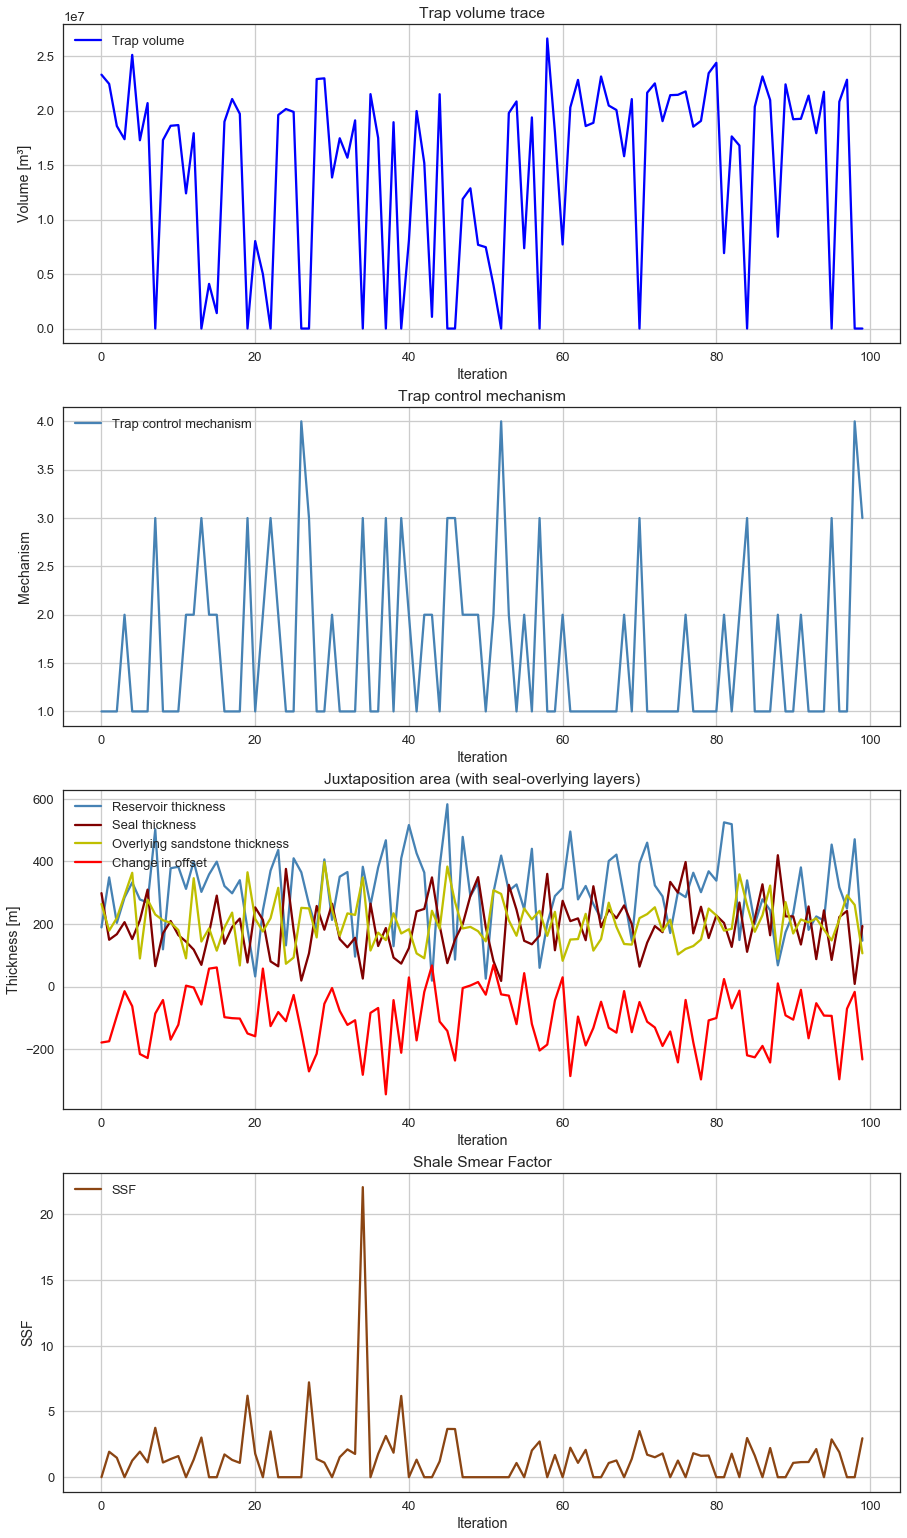

In [29]:
figsize(15,27)
fig, ax = plt.subplots(4, 1)

ax[0].plot(max_volume_trace, color='b', label='Trap volume')
ax[0].set_title('Trap volume trace')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Volume [m³]')
ax[0].legend(loc="upper left")
ax[0].grid()

ax[1].plot(trap_control_trace, color='steelblue', label='Trap control mechanism')
ax[1].set_title('Trap control mechanism')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Mechanism')
ax[1].legend(loc="upper left")
ax[1].grid()

ax[2].plot(fw_res_th_trace, color='steelblue', label='Reservoir thickness')
ax[2].plot(fw_seal_th_trace, color='maroon', label='Seal thickness')
ax[2].plot(fw_sec_res_th_trace, color='y', label='Overlying sandstone thickness')
ax[2].plot(offset_unc_trace*rescale_f, color='r', label='Change in offset')
ax[2].set_title('Juxtaposition area (with seal-overlying layers)')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Thickness [m]')
ax[2].legend(loc="upper left")
ax[2].grid()

ax[3].plot(SSF_trace, color='saddlebrown', label='SSF')
ax[3].set_title('Shale Smear Factor')
ax[3].set_xlabel('Iteration')
ax[3].set_ylabel('SSF')
ax[3].legend(loc="upper left")
ax[3].grid()

#ax[4].plot(over_jux_area_trace, color='g', label='Juxtaposition area')
#ax[4].set_title('Juxtaposition area (with seal-overlying layers)')
#ax[4].set_xlabel('Iteration')
#ax[4].set_ylabel('Area [m²]')
#ax[4].legend(loc="upper left")
#ax[4].grid()

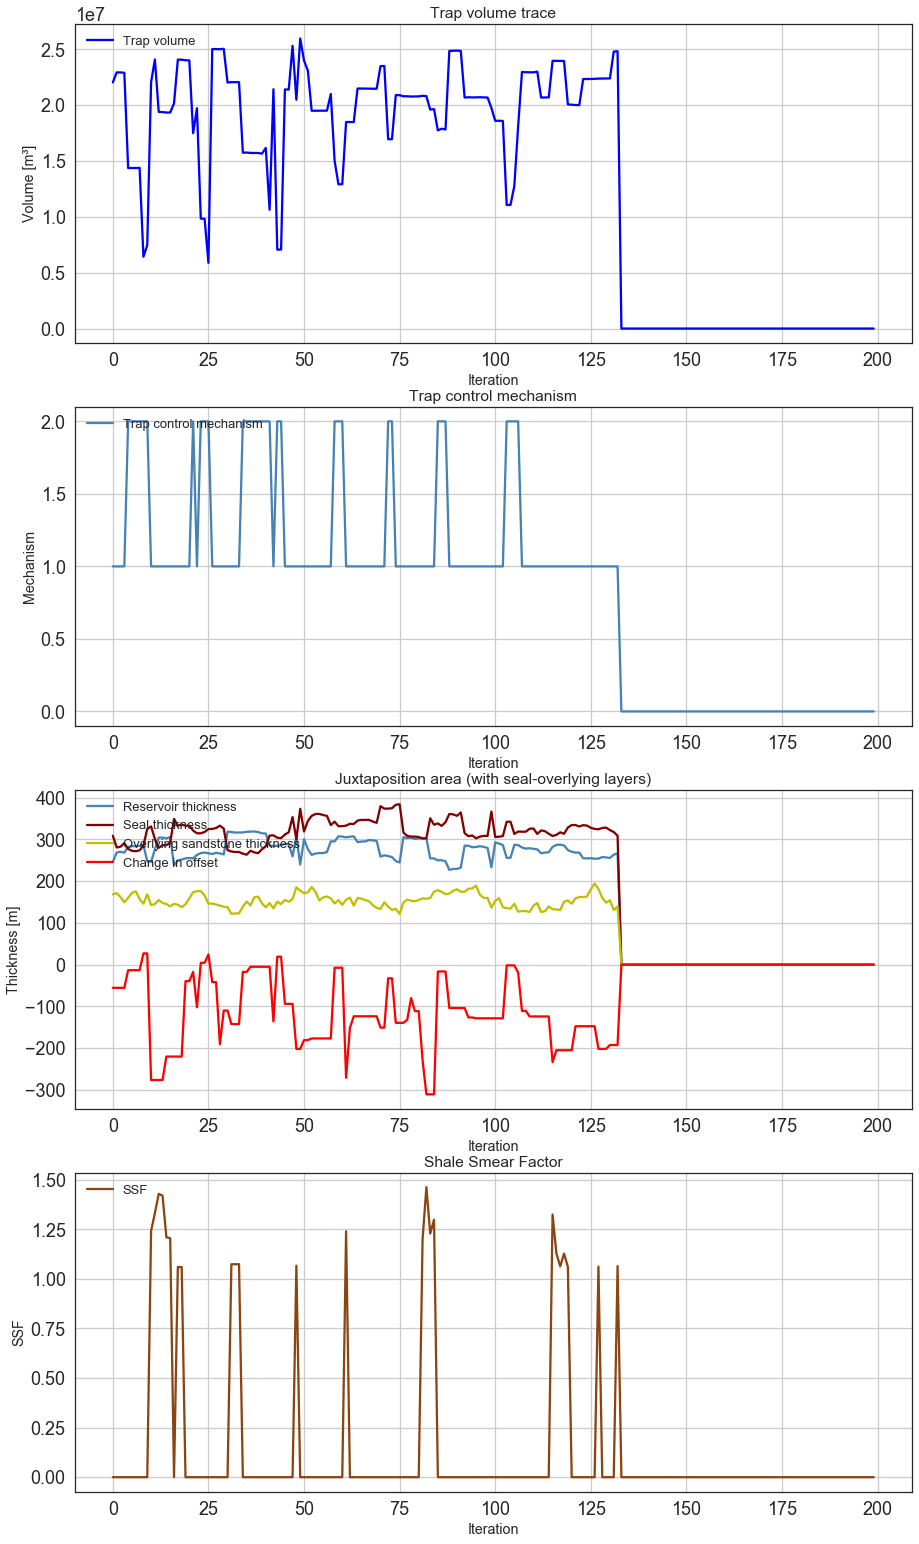

In [39]:
figsize(15,27)
fig, ax = plt.subplots(4, 1)

ax[0].plot(max_volume_trace_L, color='b', label='Trap volume')
ax[0].set_title('Trap volume trace')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Volume [m³]')
ax[0].legend(loc="upper left")
ax[0].grid()

ax[1].plot(trap_control_trace_L, color='steelblue', label='Trap control mechanism')
ax[1].set_title('Trap control mechanism')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Mechanism')
ax[1].legend(loc="upper left")
ax[1].grid()

ax[2].plot(fw_res_th_trace_L, color='steelblue', label='Reservoir thickness')
ax[2].plot(fw_seal_th_trace_L, color='maroon', label='Seal thickness')
ax[2].plot(fw_sec_res_th_trace_L, color='y', label='Overlying sandstone thickness')
ax[2].plot(offset_unc_trace_L*rescale_f, color='r', label='Change in offset')
ax[2].set_title('Juxtaposition area (with seal-overlying layers)')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Thickness [m]')
ax[2].legend(loc="upper left")
ax[2].grid()

ax[3].plot(SSF_trace_L, color='saddlebrown', label='SSF')
ax[3].set_title('Shale Smear Factor')
ax[3].set_xlabel('Iteration')
ax[3].set_ylabel('SSF')
ax[3].legend(loc="upper left")
ax[3].grid()

#ax[4].plot(over_jux_area_trace_L, color='g', label='Juxtaposition area')
#ax[4].set_title('Juxtaposition area (with seal-overlying layers)')
#ax[4].set_xlabel('Iteration')
#ax[4].set_ylabel('Area [m²]')
#ax[4].legend(loc="upper left")
#ax[4].grid()

In [27]:
lith_blocks = []
for i in structural_model_trace_L[:]:
    #print(i[0][0])
    lith_blocks.append(i[0][0])

lith_prob = compute_prob_lith(lith_blocks)
i_entropy = calculate_ie_masked(lith_prob)

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  """


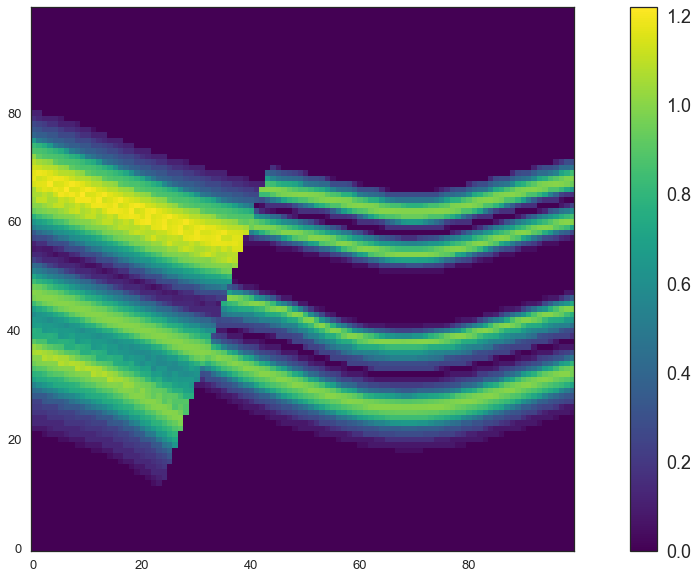

In [28]:
figsize(20,10)
fig, ax = plt.subplots(1)
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
plt.imshow(i_entropy.reshape(resolution,resolution,resolution)[:,resolution/2,:].T, origin="lower", cmap="viridis")
plt.colorbar()

Bayes action (minimum) at risk r 0.50: 20480000.00 --- expected loss: 2400390.00
Bayes action (minimum) at risk r 0.75: 20416000.00 --- expected loss: 3427900.00
Bayes action (minimum) at risk r 1.00: 18856000.00 --- expected loss: 4299340.00
Bayes action (minimum) at risk r 1.25: 18640000.00 --- expected loss: 5061300.00
Bayes action (minimum) at risk r 1.50: 18408000.00 --- expected loss: 5799120.00


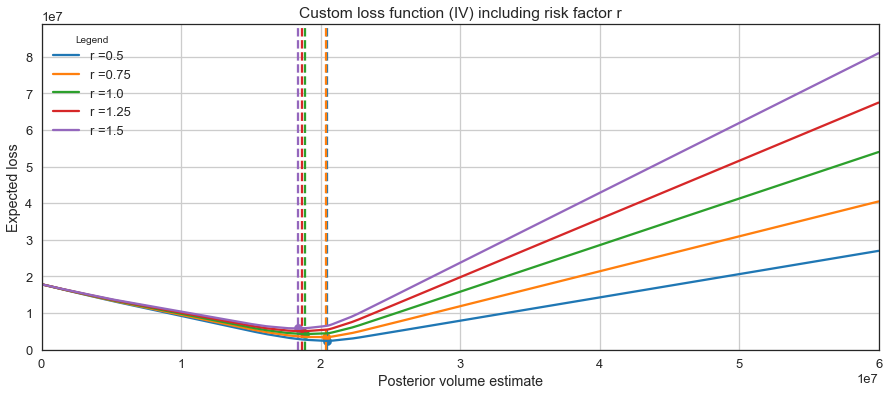

In [38]:
figsize(15, 6)

ax = plt.subplot(111)
expected_loss_s = lambda estimate_s, risk_s: volume_lossR(estimate_s, max_volume_trace_L, risk_s).mean()

for r in risks_s:
    _color = next(ax._get_lines.prop_cycler)
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _min_vol = sop.fmin(expected_loss_s, -40, args=(r,),disp = False)
    if _min_vol < 0:
        _min_vol = 0
    plt.plot(estimates_s, loss, label = "r ="+str(r), color=_color['color'])
    plt.scatter(_min_vol, expected_loss_s(_min_vol,r), s = 70, color=_color['color'])#, label = "Bayes action r "+str(r))
    plt.vlines(_min_vol, 0, 10 * np.max(loss), color=_color['color'], linestyles="--")
    print("Bayes action (minimum) at risk r %.2f: %.2f --- expected loss: %.2f" % (r, _min_vol,\
                                                                              expected_loss_s(_min_vol,r)))
    
plt.title("""Custom loss function (IV) including risk factor r""")    
plt.legend(loc="upper left", scatterpoints=1, title="Legend")

plt.xlabel("Posterior volume estimate")
plt.ylabel("Expected loss")
plt.xlim(estimates_s[0], estimates_s[-1])
plt.ylim(0,1.1 * np.max(loss))
plt.grid()


In [54]:
# FOR EXPORTING TO USE IN PARAVIEW:
export = False

if export:
    counter = 0
    for i in structural_model_trace[:]:
        counter+=1
        #print(np.ascontiguousarray(i[3]))
        gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[3]), path="./output_data/trap_volumes/14_11-TRAP_100iterUNC_PRIORonly_%s" % (counter))
        gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[0][0]), path="./output_data/lith_blocks/14_11-LITH_100iterUNC_PRIORonly_%s" % (counter))

In [ ]:
#import graphviz
#pymc.graph.dag(model)

In [ ]:
#sys.path.append("/home/bl9/Theses/Risk\ analysis/Notebooks")
#graph = pymc.graph.graph(model)
#graph.write_png()